# I. Lấy thông tin

## 1 Khai báo thư viện

In [151]:
import csv
import os
import math
import cv2
#import glob
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
# display plots in this notebook
%matplotlib inline

In [2]:
import SimpleITK
import SimpleITK as sitk
from PIL import Image
from random import shuffle

In [3]:
from tqdm import tqdm
import pandas as pd
import keras as k
from keras.models import Sequential ,Model
from keras.layers import Conv2D, MaxPooling2D,AveragePooling3D,AveragePooling2D,MaxPooling3D,Conv3D
from keras.layers import Activation, Dropout, Flatten, Dense ,Input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing import image
from keras import applications

C:\Users\vuong.huynh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
## Sử dụng GPU
import tensorflow as tf
from keras.backend import tensorflow_backend
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

## 2. Load file dữ liệu csv

In [5]:
DataCandidates = pd.read_csv("F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/CSVFILES/candidates.csv")

In [6]:
DataCandidates.shape

(551065, 5)

In [7]:
DataCandidates.head()

seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -56.08  -67.85 -311.92   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   53.21 -244.41 -245.17   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.66 -121.80 -286.62   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -33.66  -72.75 -308.41   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -32.25  -85.36 -362.51   

   class  
0      0  
1      0  
2      0  
3      0  
4      0

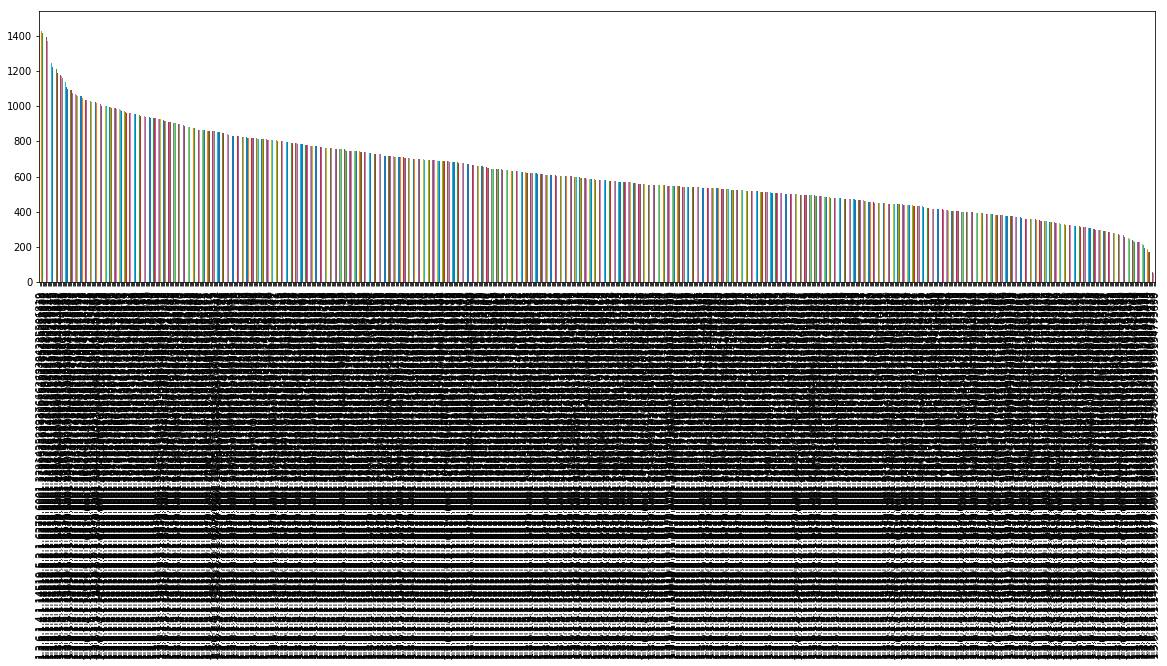

In [8]:
CountDataCandidates = DataCandidates['seriesuid'].value_counts()
plt.figure(figsize =(20,5))
CountDataCandidates.plot.bar()

Trong tập dữ liệu này có 551065 dòng nhưng trong tập subset có tất cả 888.
=> 1 file được dánh dấu nhiều vị trí. Ứng với mỗi vị trí đánh dấu sẽ có phân tích khác nhau.

In [9]:
DataCandidates['class'].value_counts()

0    549714
1      1351
Name: class, dtype: int64

Trong tập dữ liệu có gán nhãn non_nodule = 549714
                                  nodule = 1351

In [10]:
CountCandidates = DataCandidates['class'].value_counts()

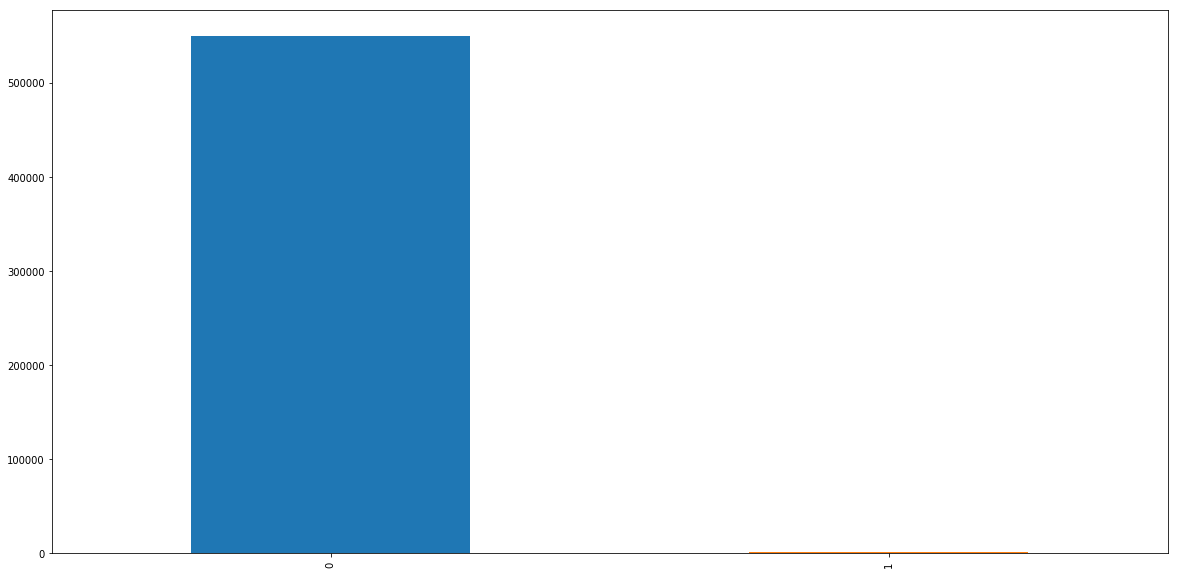

In [11]:
plt.figure(figsize =(20,10))
CountCandidates.plot.bar()

## 3. Load file mdh và hiển thị hình ảnh

### 3.1 Load file trong tập subset0

In [12]:
File1 = "F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd"
File2 = "F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"
File3 = "F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd"
File4 = "F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd"

In [13]:
img1 = SimpleITK.ReadImage(File1)
img2 = SimpleITK.ReadImage(File2)
img3 = SimpleITK.ReadImage(File3)
img4 = SimpleITK.ReadImage(File4)

In [14]:
sitk.GetArrayFromImage(img1)

array([[[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ...,
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024]],

       [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ...,
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024]],

       [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ...,
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -30

In [15]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

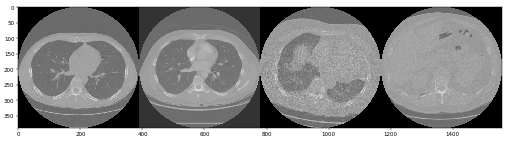

In [16]:
idxSlice = 50
sitk_show(SimpleITK.Tile(img1[:, :, idxSlice],img2[:, :, idxSlice],img3[:, :, idxSlice],img4[:, :, idxSlice],(4, 1, 0)))

In [17]:
DiaChiFolder="F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset0/"

In [18]:
import glob

In [19]:
def LayThongTinTrongFolder(DiaChiFolder):
    DiaChi = glob.glob(DiaChiFolder + "*.mhd")
    TenFile = []
    DiaChiFile =[]
    for sq in DiaChi:
        link = sq.replace('\\', '/')
        #img = io.imread(link, plugin='simpleitk')
        File = link.split('/')[5]
        FileName = File.split(".mhd")[0]
        TenFile.append(FileName)
        DiaChiFile.append(link)
    return DiaChiFile, TenFile

In [20]:
DiaChiFile, TenFile = LayThongTinTrongFolder(DiaChiFolder)

In [21]:
#Hiển thị hình ảnh cắt lớp
def plot_mhd_file(file):
    Img = SimpleITK.ReadImage(file) 
    arrImg = sitk.GetArrayFromImage(Img)
    n_images = arrImg.shape[0]
    print(n_images)
    ncol = 12
    nrow = math.ceil(n_images / ncol)
    plt.figure(figsize=(16, 16))
    for i in range(120):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(arrImg[i])

121


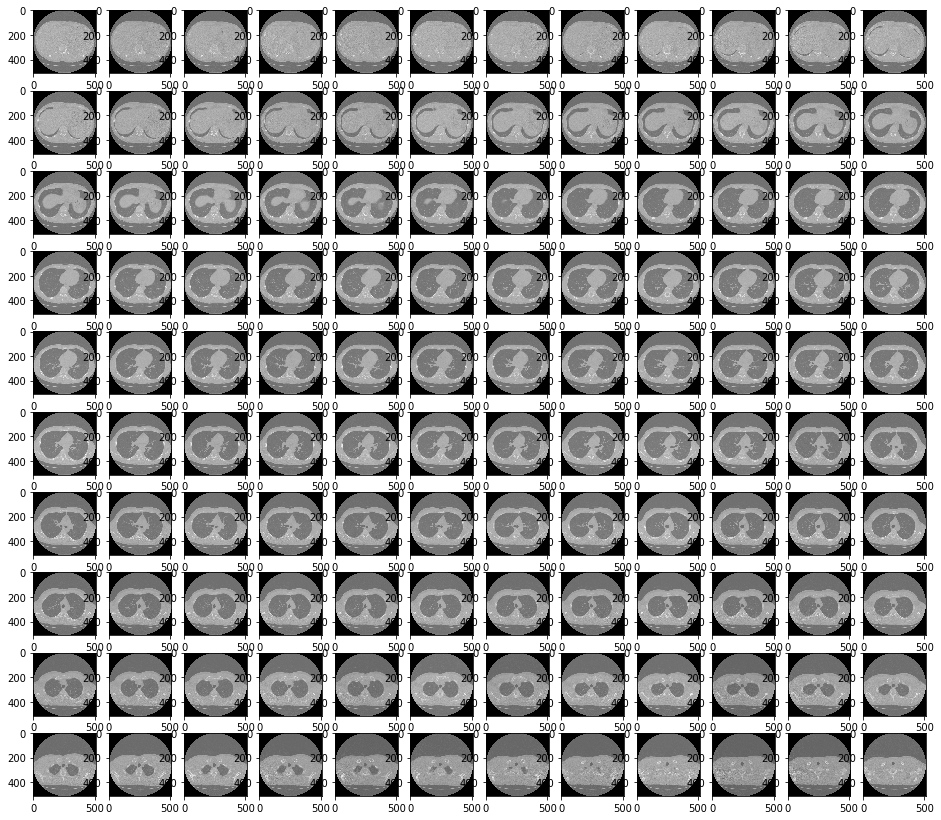

In [22]:
plot_mhd_file(DiaChiFile[0])

# 3.2 Hiển thị hình ảnh theo tọa độ

In [23]:
file_list = glob.glob(DiaChiFolder + "*.mhd")

In [24]:
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return (f)

In [25]:
#Chỉ lấy những giá trị có tồn tại trong folder subset0
df_node = DataCandidates
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

In [26]:
df_node.head()

seriesuid      coordX  \
9310  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  129.568151   
9311  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -97.260000   
9312  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...   99.230491   
9313  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -15.287525   
9314  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  109.344666   

         coordY      coordZ  class  \
9310  45.377097 -277.835758      0   
9311  56.360000 -201.930000      0   
9312  -4.882165 -128.691305      0   
9313 -59.105100 -251.303750      0   
9314   1.891737 -237.284699      0   

                                                   file  
9310  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
9311  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
9312  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
9313  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
9314  F:/8_Machine Learning/Bai tap Deeplearning/5_L...

In [82]:
df_node.shape

(56938, 6)

#### Tạo bảng dữ liệu có Nodule (Class =1)

In [27]:
DataNodule = df_node[df_node['class']==1]

In [28]:
DataNodule['file'] = DataNodule['file'].str.replace('\\', '/')

C:\Users\vuong.huynh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
DataNodule.head()

seriesuid      coordX  \
15647  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.460000   
16831  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.540000   
16978  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   44.250000   
17222  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   46.003141   
20044  1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.310000   

           coordY      coordZ  class  \
15647   68.010000 -230.550000      1   
16831   78.100000 -122.920000      1   
16978   52.170000 -110.250000      1   
17222   47.665253 -108.482213      1   
20044  116.670000 -181.890000      1   

                                                    file  
15647  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
16831  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
16978  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
17222  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
20044  F:/8_Machine Learning/Bai tap Deeplearning/5_L...

#### Tạo bảng dữ liệu non_nodule (Class =0)

In [30]:
DataNon_Nodule = df_node[df_node['class']==0]

In [31]:
DataNon_Nodule['file'] = DataNon_Nodule['file'].str.replace('\\', '/')

C:\Users\vuong.huynh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
DataNon_Nodule.head()

seriesuid      coordX  \
9310  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  129.568151   
9311  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -97.260000   
9312  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...   99.230491   
9313  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -15.287525   
9314  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  109.344666   

         coordY      coordZ  class  \
9310  45.377097 -277.835758      0   
9311  56.360000 -201.930000      0   
9312  -4.882165 -128.691305      0   
9313 -59.105100 -251.303750      0   
9314   1.891737 -237.284699      0   

                                                   file  
9310  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
9311  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
9312  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
9313  F:/8_Machine Learning/Bai tap Deeplearning/5_L...  
9314  F:/8_Machine Learning/Bai tap Deeplearning/5_L...

In [33]:
def load_Info_image(filename):
    itkimage = sitk.ReadImage(filename)
    arrImage = sitk.GetArrayFromImage(itkimage)
    Origin = np.array(itkimage.GetOrigin())
    Spacing = np.array(itkimage.GetSpacing())
    return arrImage, Origin, Spacing

In [34]:
import matplotlib.patches as patches
def VeKhungTheoToaDo(arrImage, ToaDo, Size):
    fig, ax = plt.subplots(1)
    ax.imshow(arrImage[ToaDo[2]], cmap=plt.cm.gray)
    ax.add_patch(patches.Rectangle((ToaDo[0] - Size/2, ToaDo[1]-Size/2),Size,Size,linewidth=2, edgecolor='r', facecolor='none'))

In [35]:
def HienThiImage(DataFrame, NumFile):
    for i in range(NumFile):
        FileNodule = DataFrame.values[i][5]
        arrImage, Origin, Spacing=load_Info_image(FileNodule)
        ToaDoXYZ = (DataFrame.values[i][1], DataFrame.values[i][2], DataFrame.values[i][3])
        DiemNodule = ((ToaDoXYZ - Origin) // Spacing).astype(np.int16)
        VeKhungTheoToaDo(arrImage,DiemNodule,64)

#### a. Hiển thị ảnh non_nodule

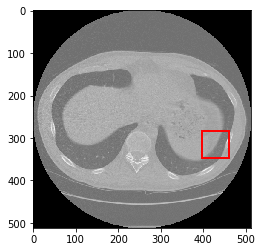

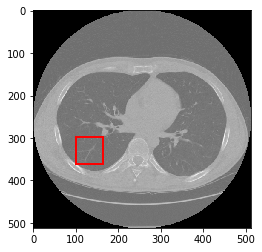

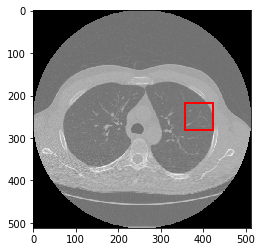

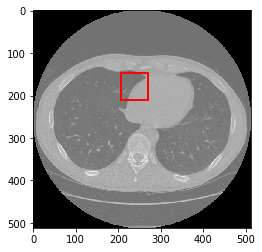

In [36]:
HienThiImage(DataNon_Nodule,4)

#### b. Hiển thị ảnh Nodule 

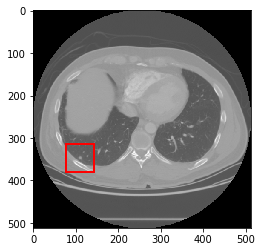

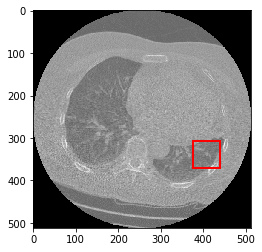

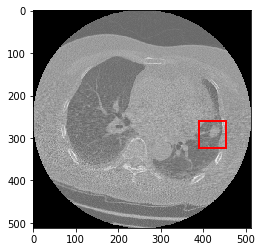

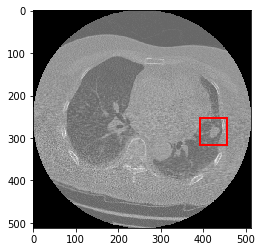

In [37]:
HienThiImage(DataNodule,4)

# II. Cắt ảnh theo khung hình

## 2.1  Xử lý trên tập Subset0

In [38]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

In [39]:
#Tọa độ 3 chiều
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

In [40]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [41]:
def readCSV(filename):
    lines = []
    with open(filename, "rb") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

In [79]:
cand_path = 'F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/CSVFILES/candidates.csv'
outdir_nodule = 'F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/nodule/'
outdir_non_nodule = 'F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/non-nodule/'
cands = pd.read_csv(cand_path , header=0)

In [85]:
count1=0
from glob import glob
for cand in tqdm(cands.values):
    path = glob('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset0/'+cand[0]+".mhd")
    if len(path)>0:
        if cand[4]==1:
            numpyImage, numpyOrigin, numpySpacing = load_itk_image(path[0])
            worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
            voxelWidth = 64
            patch = numpyImage[int(voxelCoord[0]-voxelWidth/2):int(voxelCoord[0]+voxelWidth/2),int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2),int(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2)]
            patch = normalizePlanes(patch)

            desired= cand[4]
            
            if(desired==0):
                yy = [0,1]
            else:
                yy= [1,0]

            np.save(outdir_nodule+str(count1)+"1X.npy",patch)
            np.save(outdir_nodule+str(count1)+"1Y.npy",yy)
            
            count1 = count1 +1
                
print(count1)




  0%|                                                                                       | 0/551065 [00:00<?, ?it/s]


  0%|▎                                                                        | 1946/551065 [00:00<00:28, 19319.44it/s]


  1%|▌                                                                        | 4529/551065 [00:00<00:24, 22480.93it/s]


  1%|▊                                                                        | 6591/551065 [00:00<00:25, 21738.98it/s]


  1%|█                                                                        | 8064/551065 [00:00<00:27, 19964.46it/s]


  2%|█▎                                                                      | 10079/551065 [00:00<00:27, 19972.12it/s]


  2%|█▌                                                                      | 11853/551065 [00:00<00:27, 19579.40it/s]


  2%|█▊                                                                      | 13622/551065 [00:00<00:27, 19318.91it/s]


  3%|██              

 52%|█████████████████████████████████████▏                                  | 284410/551065 [01:26<01:20, 3304.12it/s]


 52%|█████████████████████████████████████▍                                  | 286863/551065 [01:26<01:19, 3328.72it/s]


 53%|█████████████████████████████████████▊                                  | 289365/551065 [01:26<01:18, 3353.84it/s]


 53%|██████████████████████████████████████▏                                 | 291919/551065 [01:26<01:16, 3379.49it/s]


 53%|██████████████████████████████████████▍                                 | 294571/551065 [01:26<01:15, 3406.22it/s]


 54%|██████████████████████████████████████▊                                 | 297046/551065 [01:26<01:14, 3430.85it/s]


 54%|███████████████████████████████████████▏                                | 299656/551065 [01:26<01:12, 3456.97it/s]


 55%|███████████████████████████████████████▍                                | 302132/551065 [01:26<01:11, 3480.81it/s]


 55%|███████████████████

122


In [86]:
count2=0
for cand in tqdm(cands.values[10000:20000]):
    path = glob('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset0/'+cand[0]+".mhd")
    if len(path)>0:
        if cand[4]==0:
            numpyImage, numpyOrigin, numpySpacing = load_itk_image(path[0])
            worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
            voxelWidth = 64
            patch = numpyImage[int(voxelCoord[0]-voxelWidth/2):int(voxelCoord[0]+voxelWidth/2),int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2),int(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2)]
            patch = normalizePlanes(patch)

            desired= cand[4]
            
            if(desired==0):
                yy = [0,1]
            else:
                yy= [1,0]

            np.save(outdir_non_nodule+str(count2)+"0X.npy",patch)
            np.save(outdir_non_nodule+str(count2)+"0Y.npy",yy)
            
            count2 = count2 +1
                
print(count2)




  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]


  0%|                                                                              | 1/10000 [00:00<2:28:46,  1.12it/s]


  0%|                                                                              | 2/10000 [00:01<1:26:05,  1.94it/s]


  0%|                                                                              | 3/10000 [00:01<1:05:05,  2.56it/s]


  0%|                                                                                | 4/10000 [00:01<56:03,  2.97it/s]


  0%|                                                                                | 5/10000 [00:01<49:19,  3.38it/s]


  0%|                                                                                | 6/10000 [00:01<44:48,  3.72it/s]


 24%|██████████████████▏                                                        | 2430/10000 [00:01<00:05, 1417.94it/s]


 47%|████████████████

 52%|███████████████████████████████████████▌                                    | 5210/10000 [00:42<00:39, 121.95it/s]


 52%|███████████████████████████████████████▌                                    | 5211/10000 [00:42<00:39, 121.54it/s]


 52%|███████████████████████████████████████▌                                    | 5212/10000 [00:43<00:39, 121.16it/s]


 52%|███████████████████████████████████████▌                                    | 5213/10000 [00:43<00:39, 120.81it/s]


 52%|███████████████████████████████████████▋                                    | 5214/10000 [00:43<00:39, 120.35it/s]


 52%|███████████████████████████████████████▋                                    | 5215/10000 [00:43<00:39, 120.03it/s]


 52%|███████████████████████████████████████▋                                    | 5216/10000 [00:43<00:40, 118.84it/s]


 52%|███████████████████████████████████████▋                                    | 5217/10000 [00:44<00:40, 118.49it/s]


 52%|███████████████████

 53%|█████████████████████████████████████████▏                                   | 5344/10000 [01:06<00:57, 80.75it/s]


 53%|█████████████████████████████████████████▏                                   | 5345/10000 [01:06<00:57, 80.60it/s]


 53%|█████████████████████████████████████████▏                                   | 5346/10000 [01:06<00:57, 80.44it/s]


 53%|█████████████████████████████████████████▏                                   | 5347/10000 [01:06<00:57, 80.31it/s]


 53%|█████████████████████████████████████████▏                                   | 5348/10000 [01:06<00:58, 80.15it/s]


 53%|█████████████████████████████████████████▏                                   | 5349/10000 [01:06<00:58, 79.98it/s]


 54%|█████████████████████████████████████████▏                                   | 5350/10000 [01:07<00:58, 79.82it/s]


 54%|█████████████████████████████████████████▏                                   | 5351/10000 [01:07<00:58, 79.66it/s]


 54%|███████████████████

 55%|██████████████████████████████████████████▏                                  | 5478/10000 [01:28<01:13, 61.71it/s]


 55%|██████████████████████████████████████████▏                                  | 5479/10000 [01:28<01:13, 61.59it/s]


 55%|██████████████████████████████████████████▏                                  | 5480/10000 [01:29<01:13, 61.51it/s]


 55%|██████████████████████████████████████████▏                                  | 5481/10000 [01:29<01:13, 61.44it/s]


 55%|██████████████████████████████████████████▏                                  | 5482/10000 [01:29<01:13, 61.37it/s]


 55%|██████████████████████████████████████████▏                                  | 5483/10000 [01:29<01:13, 61.28it/s]


 55%|██████████████████████████████████████████▏                                  | 5484/10000 [01:29<01:13, 61.19it/s]


 55%|██████████████████████████████████████████▏                                  | 5485/10000 [01:29<01:13, 61.11it/s]


 55%|███████████████████

 56%|███████████████████████████████████████████▏                                 | 5612/10000 [01:52<01:28, 49.81it/s]


 56%|███████████████████████████████████████████▏                                 | 5613/10000 [01:52<01:28, 49.75it/s]


 56%|███████████████████████████████████████████▏                                 | 5614/10000 [01:53<01:28, 49.67it/s]


 56%|███████████████████████████████████████████▏                                 | 5615/10000 [01:53<01:28, 49.49it/s]


 56%|███████████████████████████████████████████▏                                 | 5616/10000 [01:53<01:28, 49.34it/s]


 56%|███████████████████████████████████████████▎                                 | 5617/10000 [01:54<01:28, 49.25it/s]


 56%|███████████████████████████████████████████▎                                 | 5618/10000 [01:54<01:29, 49.21it/s]


 56%|███████████████████████████████████████████▎                                 | 5619/10000 [01:54<01:29, 49.16it/s]


 56%|███████████████████

 57%|████████████████████████████████████████████▎                                | 5747/10000 [02:15<01:40, 42.36it/s]


 57%|████████████████████████████████████████████▎                                | 5748/10000 [02:15<01:40, 42.32it/s]


 57%|████████████████████████████████████████████▎                                | 5749/10000 [02:16<01:40, 42.26it/s]


 57%|████████████████████████████████████████████▎                                | 5750/10000 [02:16<01:40, 42.23it/s]


 58%|████████████████████████████████████████████▎                                | 5751/10000 [02:16<01:40, 42.15it/s]


 58%|████████████████████████████████████████████▎                                | 5752/10000 [02:16<01:40, 42.11it/s]


 58%|████████████████████████████████████████████▎                                | 5753/10000 [02:16<01:40, 42.08it/s]


 58%|████████████████████████████████████████████▎                                | 5754/10000 [02:16<01:41, 42.04it/s]


 58%|███████████████████

 59%|█████████████████████████████████████████████▎                               | 5881/10000 [02:38<01:50, 37.19it/s]


 59%|█████████████████████████████████████████████▎                               | 5882/10000 [02:38<01:50, 37.16it/s]


 59%|█████████████████████████████████████████████▎                               | 5883/10000 [02:38<01:50, 37.14it/s]


 59%|█████████████████████████████████████████████▎                               | 5884/10000 [02:38<01:50, 37.11it/s]


 59%|█████████████████████████████████████████████▎                               | 5885/10000 [02:38<01:50, 37.08it/s]


 59%|█████████████████████████████████████████████▎                               | 5886/10000 [02:38<01:51, 37.05it/s]


 59%|█████████████████████████████████████████████▎                               | 5887/10000 [02:38<01:51, 37.03it/s]


 59%|█████████████████████████████████████████████▎                               | 5888/10000 [02:39<01:51, 37.00it/s]


 59%|███████████████████

 60%|██████████████████████████████████████████████▎                              | 6015/10000 [03:00<01:59, 33.29it/s]


 60%|██████████████████████████████████████████████▎                              | 6016/10000 [03:00<01:59, 33.28it/s]


 60%|██████████████████████████████████████████████▎                              | 6017/10000 [03:00<01:59, 33.26it/s]


 60%|██████████████████████████████████████████████▎                              | 6018/10000 [03:01<01:59, 33.24it/s]


 60%|██████████████████████████████████████████████▎                              | 6019/10000 [03:01<01:59, 33.21it/s]


 60%|██████████████████████████████████████████████▎                              | 6020/10000 [03:01<01:59, 33.18it/s]


 60%|██████████████████████████████████████████████▎                              | 6021/10000 [03:01<01:59, 33.16it/s]


 60%|██████████████████████████████████████████████▎                              | 6022/10000 [03:01<02:00, 33.14it/s]


 60%|███████████████████

 69%|█████████████████████████████████████████████████████                        | 6896/10000 [03:34<01:36, 32.09it/s]


 69%|█████████████████████████████████████████████████████                        | 6897/10000 [03:35<01:36, 32.06it/s]


 69%|█████████████████████████████████████████████████████                        | 6898/10000 [03:35<01:36, 32.04it/s]


 69%|█████████████████████████████████████████████████████                        | 6899/10000 [03:35<01:36, 32.01it/s]


 69%|█████████████████████████████████████████████████████▏                       | 6900/10000 [03:35<01:36, 31.99it/s]


 69%|█████████████████████████████████████████████████████▏                       | 6901/10000 [03:35<01:36, 31.98it/s]


 69%|█████████████████████████████████████████████████████▏                       | 6902/10000 [03:36<01:36, 31.95it/s]


 69%|█████████████████████████████████████████████████████▏                       | 6903/10000 [03:36<01:36, 31.93it/s]


 69%|███████████████████

 70%|██████████████████████████████████████████████████████▏                      | 7031/10000 [04:06<01:44, 28.49it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7032/10000 [04:07<01:44, 28.46it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7033/10000 [04:07<01:44, 28.44it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7034/10000 [04:07<01:44, 28.41it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7035/10000 [04:07<01:44, 28.39it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7036/10000 [04:07<01:44, 28.37it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7037/10000 [04:08<01:44, 28.35it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7038/10000 [04:08<01:44, 28.33it/s]


 70%|███████████████████

 72%|███████████████████████████████████████████████████████▏                     | 7165/10000 [04:36<01:49, 25.95it/s]


 72%|███████████████████████████████████████████████████████▏                     | 7166/10000 [04:36<01:49, 25.93it/s]


 72%|███████████████████████████████████████████████████████▏                     | 7167/10000 [04:36<01:49, 25.92it/s]


 72%|███████████████████████████████████████████████████████▏                     | 7168/10000 [04:36<01:49, 25.90it/s]


 72%|███████████████████████████████████████████████████████▏                     | 7169/10000 [04:37<01:49, 25.88it/s]


 72%|███████████████████████████████████████████████████████▏                     | 7170/10000 [04:37<01:49, 25.85it/s]


 72%|███████████████████████████████████████████████████████▏                     | 7171/10000 [04:37<01:49, 25.84it/s]


 72%|███████████████████████████████████████████████████████▏                     | 7172/10000 [04:37<01:49, 25.82it/s]


 72%|███████████████████

 98%|███████████████████████████████████████████████████████████████████████████▊ | 9850/10000 [05:34<00:05, 29.47it/s]


 99%|███████████████████████████████████████████████████████████████████████████▊ | 9851/10000 [05:34<00:05, 29.42it/s]


 99%|███████████████████████████████████████████████████████████████████████████▊ | 9852/10000 [05:35<00:05, 29.38it/s]


 99%|███████████████████████████████████████████████████████████████████████████▊ | 9853/10000 [05:35<00:05, 29.33it/s]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 9854/10000 [05:36<00:04, 29.28it/s]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 9855/10000 [05:37<00:04, 29.23it/s]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 9856/10000 [05:37<00:04, 29.19it/s]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 9857/10000 [05:38<00:04, 29.14it/s]


 99%|███████████████████

100%|████████████████████████████████████████████████████████████████████████████▉| 9984/10000 [06:52<00:00, 24.22it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9985/10000 [06:52<00:00, 24.19it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9986/10000 [06:53<00:00, 24.16it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9987/10000 [06:53<00:00, 24.13it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9988/10000 [06:54<00:00, 24.10it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9989/10000 [06:54<00:00, 24.07it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9990/10000 [06:55<00:00, 24.04it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9991/10000 [06:56<00:00, 24.01it/s]


100%|███████████████████

1803


### a. Hình ảnh nodule sau khi cắt

In [94]:
ListFile = glob('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/nodule/*X.npy')

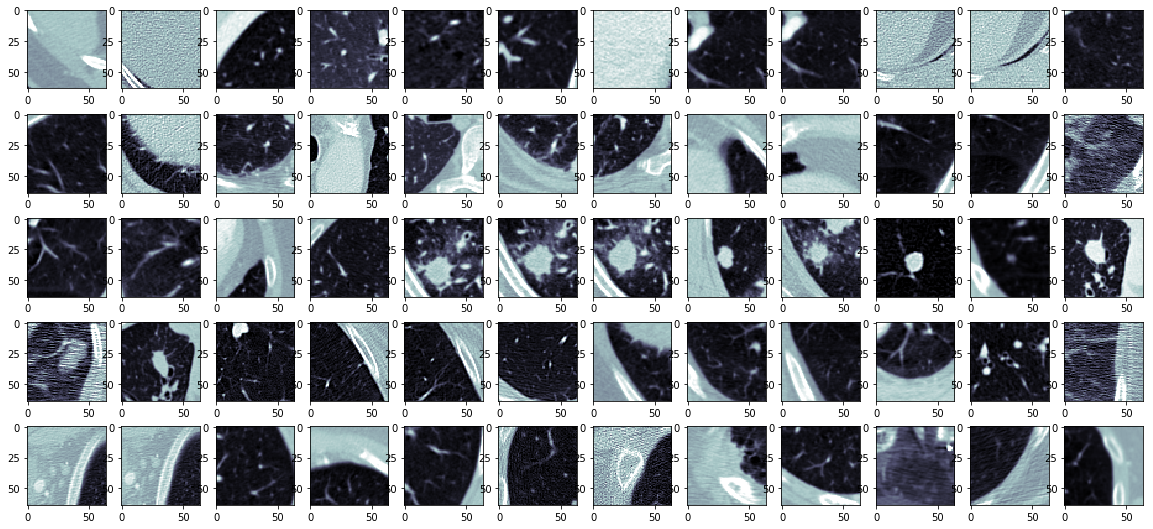

In [119]:
fig = plt.figure(figsize=(20,15))
for i in range(60):
    imgs_to_process = np.load(ListFile[i]).astype(np.float64)
    plt.subplot(8, 12, i+1)
    _ = plt.imshow(imgs_to_process[i,:,:], 'bone')
    #ax = fig.add_subplot(1,3,i+1)
    #ax.imshow(imgs_to_process[i,:,:], 'bone')
    #ax.set_axis_off()
plt.show()
    

### b. Hình ảnh non-nodule sau khi cắt

In [120]:
ListFileNon = glob('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/non-nodule/*X.npy')

In [122]:
ListFileNon[1]

'F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/non-nodule\\10000X.npy'

0
5
29
36
39
40
42
47
51
53
58


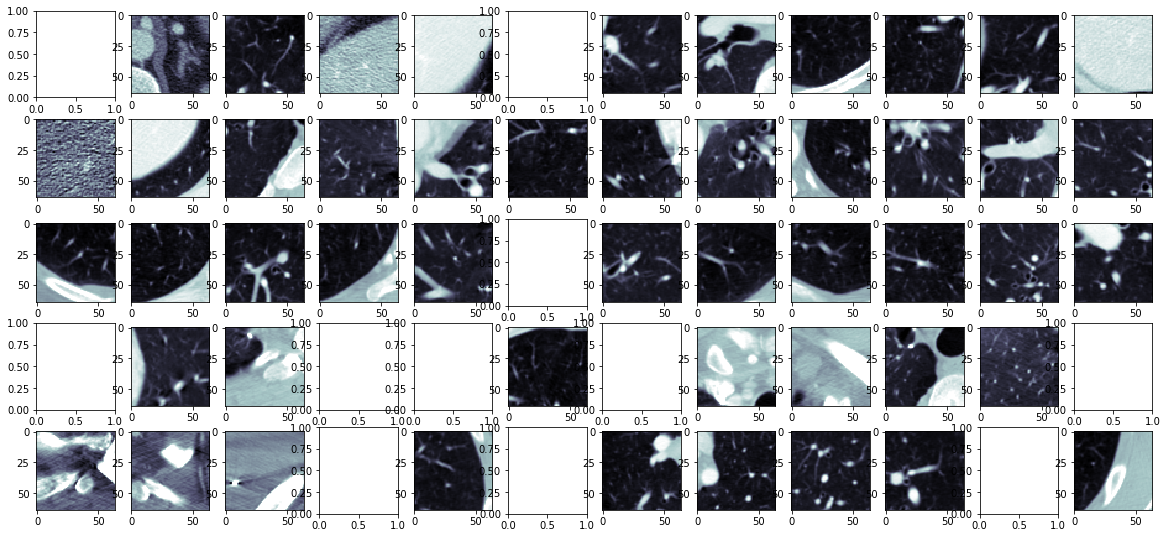

In [134]:
fig = plt.figure(figsize=(20,15))
for i in range(60):
    try:
        imgs_to_process = np.load(ListFileNon[i]).astype(np.float64)
        plt.subplot(8, 12, i+1)
        _ = plt.imshow(imgs_to_process[i,:,:], 'bone')
    #ax = fig.add_subplot(1,3,i+1)
    #ax.imshow(imgs_to_process[i,:,:], 'bone')
    #ax.set_axis_off()
    except IndexError:
        print(i)
plt.show()

## c. Load dữ liệu

In [136]:
xtrain = []
ytrain = []
ListFileNodule = glob(outdir_nodule+"*X.npy")
ListFileNonNodule= glob(outdir_non_nodule+"*X.npy")
#Lấy sample 500 data Nodule và 500 Non Nodule
TotalList = ListFileNodule[:500] + ListFileNonNodule[:500]
#Random dữ liệu
shuffle(TotalList)
for x in TotalList:
    y = x[:-5] +"Y" + x[-4:]
    xx= np.load(x)
    yy = np.load(y)
    if xx.shape == (64,64,64):
        xx = np.expand_dims(xx,axis=3)
        xtrain.append(xx)
        ytrain.append(yy)
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

In [137]:
xtrain.shape , ytrain.shape

((543, 64, 64, 64, 1), (543, 2))

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

### d. Traing by CNN

In [143]:
def makevanilla():
    x = Input(shape=(64,64,64,1))
    conv0= Conv3D(32,kernel_size=(3,3,3),padding="same",activation='relu')(x)
    conv0= Dropout(0.2)(conv0)
    avg1 = AveragePooling3D(pool_size=(2,1,1))(conv0)
    conv1= Conv3D(32,kernel_size=(3,3,3),padding="same",activation='relu')(avg1)
    conv1= Dropout(0.2)(conv1)
    max1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2= Conv3D(64,kernel_size=(3,3,3),padding="same",activation='relu')(max1)
    conv2= Dropout(0.2)(conv2)
    max2 = MaxPooling3D(pool_size=(2,2,2))(conv2)
    conv3= Conv3D(128,kernel_size=(3,3,3),padding="same",activation='relu')(max2)
    conv3= Dropout(0.2)(conv3)
    max3 = MaxPooling3D(pool_size=(2,2,2))(conv3)
    conv4= Conv3D(256,kernel_size=(3,3,3),padding="same",activation='relu')(max3)
    conv4= Dropout(0.2)(conv4)
    max4 = MaxPooling3D(pool_size=(2,2,2))(conv4)
    conv5= Conv3D(256,kernel_size=(3,3,3),padding="same",activation='relu')(max4)
    conv5= Dropout(0.2)(conv5)
    max5 = MaxPooling3D(pool_size=(2,2,2))(conv5)
    conv6= Conv3D(512,kernel_size=(3,3,3),padding="same",activation='relu')(max5)

    flat = Flatten()(conv6)
    flat= Dropout(0.2)(flat)
    dense= Dense(2,activation="softmax")(flat)

    vanillamodel = Model(inputs=x, outputs=dense)
    
    vanillamodel.compile(loss=k.losses.categorical_crossentropy,
              optimizer=k.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

    return vanillamodel

In [144]:
vanilla3d = makevanilla()
vanilla3d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 64, 1)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 64, 64, 64, 32)    896       
_________________________________________________________________
dropout_40 (Dropout)         (None, 64, 64, 64, 32)    0         
_________________________________________________________________
average_pooling3d_6 (Average (None, 32, 64, 64, 32)    0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 32, 64, 64, 32)    27680     
_________________________________________________________________
dropout_41 (Dropout)         (None, 32, 64, 64, 32)    0         
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 16, 32, 32, 32)    0         
__________

In [145]:
historyVanilla= vanilla3d.fit(X_train,y_train,batch_size=10,epochs=20,verbose=1,validation_data=( X_test, y_test))

Train on 434 samples, validate on 109 samples
Epoch 1/20
434/434 [==============================] - ETA: 1:34 - loss: 0.6786 - acc: 0.900 - ETA: 59s - loss: 0.6728 - acc: 0.750 - ETA: 47s - loss: 0.6768 - acc: 0.70 - ETA: 40s - loss: 0.6422 - acc: 0.72 - ETA: 36s - loss: 0.5945 - acc: 0.76 - ETA: 33s - loss: 0.5477 - acc: 0.78 - ETA: 31s - loss: 0.5853 - acc: 0.77 - ETA: 29s - loss: 0.5861 - acc: 0.77 - ETA: 27s - loss: 0.5363 - acc: 0.80 - ETA: 26s - loss: 0.5360 - acc: 0.80 - ETA: 25s - loss: 0.5292 - acc: 0.80 - ETA: 24s - loss: 0.5140 - acc: 0.80 - ETA: 23s - loss: 0.5097 - acc: 0.80 - ETA: 22s - loss: 0.5054 - acc: 0.80 - ETA: 21s - loss: 0.5100 - acc: 0.80 - ETA: 20s - loss: 0.5090 - acc: 0.80 - ETA: 19s - loss: 0.5142 - acc: 0.79 - ETA: 18s - loss: 0.5294 - acc: 0.78 - ETA: 17s - loss: 0.5309 - acc: 0.77 - ETA: 16s - loss: 0.5311 - acc: 0.78 - ETA: 16s - loss: 0.5299 - acc: 0.78 - ETA: 15s - loss: 0.5255 - acc: 0.79 - ETA: 14s - loss: 0.5239 - acc: 0.79 - ETA: 13s - loss: 0.5248

434/434 [==============================] - ETA: 26s - loss: 0.0159 - acc: 1.00 - ETA: 26s - loss: 0.1520 - acc: 0.95 - ETA: 25s - loss: 0.1427 - acc: 0.93 - ETA: 25s - loss: 0.1214 - acc: 0.95 - ETA: 24s - loss: 0.0998 - acc: 0.96 - ETA: 23s - loss: 0.1162 - acc: 0.95 - ETA: 23s - loss: 0.1333 - acc: 0.94 - ETA: 22s - loss: 0.1355 - acc: 0.93 - ETA: 21s - loss: 0.1291 - acc: 0.94 - ETA: 21s - loss: 0.1168 - acc: 0.95 - ETA: 20s - loss: 0.1117 - acc: 0.95 - ETA: 20s - loss: 0.1035 - acc: 0.95 - ETA: 19s - loss: 0.1028 - acc: 0.96 - ETA: 18s - loss: 0.0976 - acc: 0.96 - ETA: 18s - loss: 0.0915 - acc: 0.96 - ETA: 17s - loss: 0.0925 - acc: 0.96 - ETA: 16s - loss: 0.1435 - acc: 0.96 - ETA: 16s - loss: 0.1388 - acc: 0.96 - ETA: 15s - loss: 0.1341 - acc: 0.96 - ETA: 15s - loss: 0.1296 - acc: 0.97 - ETA: 14s - loss: 0.1299 - acc: 0.96 - ETA: 13s - loss: 0.1303 - acc: 0.96 - ETA: 13s - loss: 0.1315 - acc: 0.96 - ETA: 12s - loss: 0.1287 - acc: 0.96 - ETA: 11s - loss: 0.1263 - acc: 0.96 - ETA: 11

434/434 [==============================] - ETA: 26s - loss: 0.0139 - acc: 1.00 - ETA: 26s - loss: 0.0101 - acc: 1.00 - ETA: 25s - loss: 0.0242 - acc: 1.00 - ETA: 25s - loss: 0.0209 - acc: 1.00 - ETA: 24s - loss: 0.0210 - acc: 1.00 - ETA: 24s - loss: 0.0215 - acc: 1.00 - ETA: 23s - loss: 0.0264 - acc: 1.00 - ETA: 22s - loss: 0.0248 - acc: 1.00 - ETA: 22s - loss: 0.0249 - acc: 1.00 - ETA: 21s - loss: 0.0241 - acc: 1.00 - ETA: 20s - loss: 0.0230 - acc: 1.00 - ETA: 20s - loss: 0.0215 - acc: 1.00 - ETA: 19s - loss: 0.0199 - acc: 1.00 - ETA: 19s - loss: 0.0204 - acc: 1.00 - ETA: 18s - loss: 0.0191 - acc: 1.00 - ETA: 17s - loss: 0.0204 - acc: 1.00 - ETA: 17s - loss: 0.0282 - acc: 0.99 - ETA: 16s - loss: 0.0381 - acc: 0.98 - ETA: 15s - loss: 0.0369 - acc: 0.98 - ETA: 15s - loss: 0.0353 - acc: 0.99 - ETA: 14s - loss: 0.0340 - acc: 0.99 - ETA: 13s - loss: 0.0336 - acc: 0.99 - ETA: 13s - loss: 0.0332 - acc: 0.99 - ETA: 12s - loss: 0.0323 - acc: 0.99 - ETA: 11s - loss: 0.0365 - acc: 0.98 - ETA: 11

In [146]:
def VeDoThiTraining(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

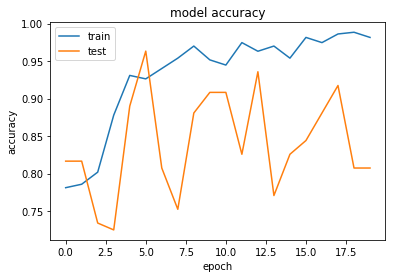

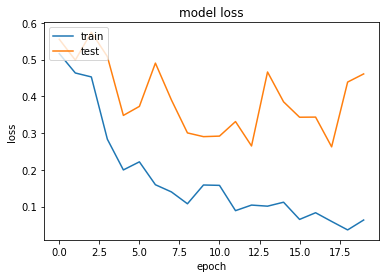

In [147]:
VeDoThiTraining(historyVanilla)

In [186]:
X_test.shape

(109, 64, 64, 64, 1)

In [187]:
predicted1 = vanilla3d.predict(X_test[:20])
pre1 = np.argmax(predicted1,axis=1)
tru1 = np.argmax(y_test[:20],axis=1)

In [188]:
from sklearn.metrics import classification_report
print(classification_report(tru1,pre1))

             precision    recall  f1-score   support

          0       0.43      1.00      0.60         3
          1       1.00      0.76      0.87        17

avg / total       0.91      0.80      0.83        20



In [154]:
xtrainF = []
ytrainF = []
ListFileNoduleF = glob(outdir_nodule+"*X.npy")
ListFileNonNoduleF= glob(outdir_non_nodule+"*X.npy")
#Lấy Full sample
TotalListF = ListFileNoduleF + ListFileNonNoduleF
#Random dữ liệu
shuffle(TotalListF)
for xF in TotalListF:
    try:
        yF = xF[:-5] +"Y" + xF[-4:]
        xxF= np.load(xF)
        yyF = np.load(yF)
        if xxF.shape == (64,64,64):
            xxF = np.expand_dims(xxF,axis=3)
            xtrainF.append(xxF)
            ytrainF.append(yyF)
    except ValueError:
        print(xF)
xtrainF = np.array(xtrainF)
ytrainF = np.array(ytrainF)

F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/non-nodule\38820_1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005_0X.npy


In [155]:
xtrainF.shape , ytrainF.shape

((1628, 64, 64, 64, 1), (1628, 2))

In [156]:
from sklearn.model_selection import train_test_split
X_trainF, X_testF, y_trainF, y_testF = train_test_split(xtrainF, ytrainF, test_size=0.2, random_state=42)

In [157]:
vanilla3dF = makevanilla()
vanilla3dF.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 64, 1)     0         
_________________________________________________________________
conv3d_44 (Conv3D)           (None, 64, 64, 64, 32)    896       
_________________________________________________________________
dropout_47 (Dropout)         (None, 64, 64, 64, 32)    0         
_________________________________________________________________
average_pooling3d_7 (Average (None, 32, 64, 64, 32)    0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 32, 64, 64, 32)    27680     
_________________________________________________________________
dropout_48 (Dropout)         (None, 32, 64, 64, 32)    0         
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 16, 32, 32, 32)    0         
__________

In [158]:
historyVanillaF= vanilla3dF.fit(X_trainF,y_trainF,batch_size=10,epochs=20,verbose=1,validation_data=(X_testF, y_testF))

Train on 1302 samples, validate on 326 samples
Epoch 1/20
1302/1302 [==============================] - ETA: 44:54 - loss: 0.6814 - acc: 0.80 - ETA: 23:32 - loss: 0.6371 - acc: 0.80 - ETA: 16:35 - loss: 0.5701 - acc: 0.83 - ETA: 14:17 - loss: 0.5138 - acc: 0.85 - ETA: 12:15 - loss: 0.5239 - acc: 0.84 - ETA: 11:02 - loss: 0.4508 - acc: 0.86 - ETA: 10:02 - loss: 0.3915 - acc: 0.88 - ETA: 9:35 - loss: 0.3463 - acc: 0.9000 - ETA: 8:50 - loss: 0.4256 - acc: 0.888 - ETA: 8:20 - loss: 0.3866 - acc: 0.900 - ETA: 8:03 - loss: 0.3535 - acc: 0.909 - ETA: 7:36 - loss: 0.3814 - acc: 0.891 - ETA: 7:14 - loss: 0.3560 - acc: 0.900 - ETA: 6:56 - loss: 0.3373 - acc: 0.907 - ETA: 6:34 - loss: 0.3334 - acc: 0.906 - ETA: 6:23 - loss: 0.3378 - acc: 0.906 - ETA: 6:23 - loss: 0.3235 - acc: 0.911 - ETA: 6:14 - loss: 0.3247 - acc: 0.911 - ETA: 5:58 - loss: 0.3139 - acc: 0.915 - ETA: 5:46 - loss: 0.3035 - acc: 0.920 - ETA: 5:36 - loss: 0.2920 - acc: 0.923 - ETA: 5:27 - loss: 0.2939 - acc: 0.922 - ETA: 5:26 - loss

1302/1302 [==============================] - ETA: 1:45 - loss: 1.1542 - acc: 0.700 - ETA: 1:47 - loss: 0.5863 - acc: 0.850 - ETA: 1:44 - loss: 0.5777 - acc: 0.833 - ETA: 1:44 - loss: 0.4541 - acc: 0.875 - ETA: 1:43 - loss: 0.3820 - acc: 0.900 - ETA: 1:42 - loss: 0.3383 - acc: 0.916 - ETA: 1:41 - loss: 0.3051 - acc: 0.928 - ETA: 1:40 - loss: 0.2786 - acc: 0.937 - ETA: 1:39 - loss: 0.2784 - acc: 0.933 - ETA: 1:38 - loss: 0.2613 - acc: 0.940 - ETA: 1:37 - loss: 0.2445 - acc: 0.945 - ETA: 1:37 - loss: 0.2495 - acc: 0.941 - ETA: 1:36 - loss: 0.2338 - acc: 0.946 - ETA: 1:35 - loss: 0.2548 - acc: 0.935 - ETA: 1:34 - loss: 0.2584 - acc: 0.933 - ETA: 1:33 - loss: 0.2461 - acc: 0.937 - ETA: 1:32 - loss: 0.2375 - acc: 0.941 - ETA: 1:31 - loss: 0.2737 - acc: 0.927 - ETA: 1:30 - loss: 0.2625 - acc: 0.931 - ETA: 1:29 - loss: 0.2522 - acc: 0.935 - ETA: 1:28 - loss: 0.2449 - acc: 0.938 - ETA: 1:28 - loss: 0.2433 - acc: 0.936 - ETA: 1:27 - loss: 0.2401 - acc: 0.934 - ETA: 1:26 - loss: 0.2408 - acc: 0.9

1302/1302 [==============================] - ETA: 1:44 - loss: 0.6223 - acc: 0.800 - ETA: 1:44 - loss: 0.3456 - acc: 0.900 - ETA: 1:44 - loss: 0.2495 - acc: 0.933 - ETA: 1:44 - loss: 0.3134 - acc: 0.900 - ETA: 1:42 - loss: 0.2593 - acc: 0.920 - ETA: 1:41 - loss: 0.2652 - acc: 0.916 - ETA: 1:40 - loss: 0.2937 - acc: 0.900 - ETA: 1:39 - loss: 0.2891 - acc: 0.900 - ETA: 1:39 - loss: 0.2691 - acc: 0.911 - ETA: 1:38 - loss: 0.2657 - acc: 0.910 - ETA: 1:37 - loss: 0.2492 - acc: 0.918 - ETA: 1:37 - loss: 0.2478 - acc: 0.916 - ETA: 1:36 - loss: 0.2332 - acc: 0.923 - ETA: 1:35 - loss: 0.2213 - acc: 0.928 - ETA: 1:34 - loss: 0.2339 - acc: 0.926 - ETA: 1:33 - loss: 0.2467 - acc: 0.918 - ETA: 1:32 - loss: 0.2341 - acc: 0.923 - ETA: 1:31 - loss: 0.2266 - acc: 0.927 - ETA: 1:31 - loss: 0.2189 - acc: 0.931 - ETA: 1:30 - loss: 0.2091 - acc: 0.935 - ETA: 1:29 - loss: 0.2006 - acc: 0.938 - ETA: 1:28 - loss: 0.2183 - acc: 0.931 - ETA: 1:27 - loss: 0.2096 - acc: 0.934 - ETA: 1:26 - loss: 0.2014 - acc: 0.9

1302/1302 [==============================] - ETA: 1:41 - loss: 0.0656 - acc: 1.000 - ETA: 1:43 - loss: 0.0625 - acc: 1.000 - ETA: 1:41 - loss: 0.2414 - acc: 0.933 - ETA: 1:40 - loss: 0.2485 - acc: 0.925 - ETA: 1:40 - loss: 0.2032 - acc: 0.940 - ETA: 1:40 - loss: 0.2640 - acc: 0.933 - ETA: 1:39 - loss: 0.2618 - acc: 0.928 - ETA: 1:38 - loss: 0.2340 - acc: 0.937 - ETA: 1:37 - loss: 0.2139 - acc: 0.944 - ETA: 1:36 - loss: 0.2122 - acc: 0.940 - ETA: 1:35 - loss: 0.1972 - acc: 0.945 - ETA: 1:35 - loss: 0.2225 - acc: 0.933 - ETA: 1:34 - loss: 0.2246 - acc: 0.923 - ETA: 1:34 - loss: 0.2296 - acc: 0.921 - ETA: 1:33 - loss: 0.2257 - acc: 0.926 - ETA: 1:32 - loss: 0.2230 - acc: 0.931 - ETA: 1:32 - loss: 0.2150 - acc: 0.935 - ETA: 1:31 - loss: 0.2123 - acc: 0.933 - ETA: 1:30 - loss: 0.2044 - acc: 0.936 - ETA: 1:29 - loss: 0.2191 - acc: 0.935 - ETA: 1:28 - loss: 0.2108 - acc: 0.938 - ETA: 1:28 - loss: 0.2056 - acc: 0.936 - ETA: 1:28 - loss: 0.2157 - acc: 0.934 - ETA: 1:27 - loss: 0.2315 - acc: 0.9

1302/1302 [==============================] - ETA: 1:43 - loss: 0.0677 - acc: 1.000 - ETA: 1:43 - loss: 0.0781 - acc: 1.000 - ETA: 1:43 - loss: 0.0711 - acc: 1.000 - ETA: 1:43 - loss: 0.0634 - acc: 1.000 - ETA: 1:43 - loss: 0.0572 - acc: 1.000 - ETA: 1:42 - loss: 0.0832 - acc: 0.983 - ETA: 1:41 - loss: 0.1670 - acc: 0.971 - ETA: 1:40 - loss: 0.1675 - acc: 0.962 - ETA: 1:39 - loss: 0.2128 - acc: 0.944 - ETA: 1:38 - loss: 0.1938 - acc: 0.950 - ETA: 1:37 - loss: 0.2089 - acc: 0.945 - ETA: 1:37 - loss: 0.2021 - acc: 0.950 - ETA: 1:36 - loss: 0.2141 - acc: 0.938 - ETA: 1:35 - loss: 0.2239 - acc: 0.928 - ETA: 1:34 - loss: 0.2243 - acc: 0.926 - ETA: 1:33 - loss: 0.2201 - acc: 0.925 - ETA: 1:32 - loss: 0.2123 - acc: 0.929 - ETA: 1:31 - loss: 0.2301 - acc: 0.916 - ETA: 1:31 - loss: 0.2233 - acc: 0.921 - ETA: 1:30 - loss: 0.2154 - acc: 0.925 - ETA: 1:29 - loss: 0.2301 - acc: 0.919 - ETA: 1:29 - loss: 0.2218 - acc: 0.922 - ETA: 1:28 - loss: 0.2141 - acc: 0.926 - ETA: 1:27 - loss: 0.2080 - acc: 0.9

1302/1302 [==============================] - ETA: 1:20 - loss: 0.2048 - acc: 1.000 - ETA: 1:22 - loss: 0.2129 - acc: 0.950 - ETA: 1:22 - loss: 0.1853 - acc: 0.966 - ETA: 1:21 - loss: 0.2718 - acc: 0.900 - ETA: 1:20 - loss: 0.2493 - acc: 0.900 - ETA: 1:19 - loss: 0.2595 - acc: 0.900 - ETA: 1:19 - loss: 0.2343 - acc: 0.914 - ETA: 1:18 - loss: 0.2682 - acc: 0.900 - ETA: 1:17 - loss: 0.2544 - acc: 0.911 - ETA: 1:16 - loss: 0.2398 - acc: 0.920 - ETA: 1:16 - loss: 0.2229 - acc: 0.927 - ETA: 1:15 - loss: 0.2312 - acc: 0.925 - ETA: 1:14 - loss: 0.2223 - acc: 0.923 - ETA: 1:14 - loss: 0.2096 - acc: 0.928 - ETA: 1:13 - loss: 0.1978 - acc: 0.933 - ETA: 1:12 - loss: 0.1867 - acc: 0.937 - ETA: 1:12 - loss: 0.1890 - acc: 0.935 - ETA: 1:11 - loss: 0.1890 - acc: 0.933 - ETA: 1:10 - loss: 0.1803 - acc: 0.936 - ETA: 1:10 - loss: 0.1927 - acc: 0.935 - ETA: 1:09 - loss: 0.1838 - acc: 0.938 - ETA: 1:08 - loss: 0.1757 - acc: 0.940 - ETA: 1:08 - loss: 0.1728 - acc: 0.939 - ETA: 1:07 - loss: 0.1715 - acc: 0.9

1302/1302 [==============================] - ETA: 1:20 - loss: 0.0250 - acc: 1.000 - ETA: 1:20 - loss: 0.0259 - acc: 1.000 - ETA: 1:20 - loss: 0.0886 - acc: 0.966 - ETA: 1:19 - loss: 0.0710 - acc: 0.975 - ETA: 1:18 - loss: 0.0598 - acc: 0.980 - ETA: 1:18 - loss: 0.1265 - acc: 0.966 - ETA: 1:17 - loss: 0.1106 - acc: 0.971 - ETA: 1:17 - loss: 0.1050 - acc: 0.975 - ETA: 1:16 - loss: 0.0953 - acc: 0.977 - ETA: 1:16 - loss: 0.1416 - acc: 0.960 - ETA: 1:15 - loss: 0.1828 - acc: 0.945 - ETA: 1:15 - loss: 0.2026 - acc: 0.941 - ETA: 1:14 - loss: 0.1899 - acc: 0.946 - ETA: 1:13 - loss: 0.1966 - acc: 0.935 - ETA: 1:13 - loss: 0.2094 - acc: 0.926 - ETA: 1:12 - loss: 0.2180 - acc: 0.925 - ETA: 1:11 - loss: 0.2195 - acc: 0.923 - ETA: 1:11 - loss: 0.2109 - acc: 0.927 - ETA: 1:10 - loss: 0.2027 - acc: 0.931 - ETA: 1:09 - loss: 0.2101 - acc: 0.930 - ETA: 1:09 - loss: 0.2041 - acc: 0.933 - ETA: 1:08 - loss: 0.2000 - acc: 0.931 - ETA: 1:08 - loss: 0.2051 - acc: 0.930 - ETA: 1:07 - loss: 0.2028 - acc: 0.9

1302/1302 [==============================] - ETA: 1:21 - loss: 0.0173 - acc: 1.000 - ETA: 1:21 - loss: 0.0159 - acc: 1.000 - ETA: 1:22 - loss: 0.0114 - acc: 1.000 - ETA: 1:21 - loss: 0.1059 - acc: 0.975 - ETA: 1:20 - loss: 0.0991 - acc: 0.980 - ETA: 1:19 - loss: 0.0986 - acc: 0.966 - ETA: 1:18 - loss: 0.0854 - acc: 0.971 - ETA: 1:17 - loss: 0.0764 - acc: 0.975 - ETA: 1:17 - loss: 0.0756 - acc: 0.977 - ETA: 1:16 - loss: 0.0683 - acc: 0.980 - ETA: 1:15 - loss: 0.0657 - acc: 0.981 - ETA: 1:15 - loss: 0.1197 - acc: 0.975 - ETA: 1:14 - loss: 0.1140 - acc: 0.976 - ETA: 1:13 - loss: 0.1062 - acc: 0.978 - ETA: 1:13 - loss: 0.1032 - acc: 0.980 - ETA: 1:12 - loss: 0.1257 - acc: 0.975 - ETA: 1:12 - loss: 0.1656 - acc: 0.964 - ETA: 1:11 - loss: 0.1657 - acc: 0.961 - ETA: 1:10 - loss: 0.1637 - acc: 0.963 - ETA: 1:10 - loss: 0.1596 - acc: 0.965 - ETA: 1:09 - loss: 0.1586 - acc: 0.966 - ETA: 1:08 - loss: 0.1565 - acc: 0.968 - ETA: 1:08 - loss: 0.1565 - acc: 0.969 - ETA: 1:07 - loss: 0.1567 - acc: 0.9

1302/1302 [==============================] - ETA: 1:21 - loss: 0.4180 - acc: 0.900 - ETA: 1:22 - loss: 0.2107 - acc: 0.950 - ETA: 1:21 - loss: 0.1430 - acc: 0.966 - ETA: 1:20 - loss: 0.1081 - acc: 0.975 - ETA: 1:20 - loss: 0.0939 - acc: 0.980 - ETA: 1:19 - loss: 0.0790 - acc: 0.983 - ETA: 1:18 - loss: 0.0687 - acc: 0.985 - ETA: 1:18 - loss: 0.0605 - acc: 0.987 - ETA: 1:18 - loss: 0.0550 - acc: 0.988 - ETA: 1:17 - loss: 0.0498 - acc: 0.990 - ETA: 1:16 - loss: 0.0457 - acc: 0.990 - ETA: 1:15 - loss: 0.1080 - acc: 0.975 - ETA: 1:15 - loss: 0.0999 - acc: 0.976 - ETA: 1:14 - loss: 0.0937 - acc: 0.978 - ETA: 1:13 - loss: 0.1244 - acc: 0.973 - ETA: 1:13 - loss: 0.1222 - acc: 0.975 - ETA: 1:13 - loss: 0.1178 - acc: 0.976 - ETA: 1:12 - loss: 0.1144 - acc: 0.977 - ETA: 1:11 - loss: 0.1113 - acc: 0.978 - ETA: 1:11 - loss: 0.1082 - acc: 0.980 - ETA: 1:10 - loss: 0.1059 - acc: 0.981 - ETA: 1:09 - loss: 0.1102 - acc: 0.977 - ETA: 1:09 - loss: 0.1068 - acc: 0.978 - ETA: 1:08 - loss: 0.1040 - acc: 0.9

1302/1302 [==============================] - ETA: 1:20 - loss: 0.0161 - acc: 1.000 - ETA: 1:21 - loss: 0.0125 - acc: 1.000 - ETA: 1:20 - loss: 0.0111 - acc: 1.000 - ETA: 1:20 - loss: 0.0233 - acc: 1.000 - ETA: 1:19 - loss: 0.0420 - acc: 0.980 - ETA: 1:19 - loss: 0.0356 - acc: 0.983 - ETA: 1:18 - loss: 0.0314 - acc: 0.985 - ETA: 1:17 - loss: 0.0894 - acc: 0.975 - ETA: 1:17 - loss: 0.0797 - acc: 0.977 - ETA: 1:16 - loss: 0.0718 - acc: 0.980 - ETA: 1:15 - loss: 0.1006 - acc: 0.972 - ETA: 1:15 - loss: 0.0924 - acc: 0.975 - ETA: 1:14 - loss: 0.1217 - acc: 0.969 - ETA: 1:14 - loss: 0.1134 - acc: 0.971 - ETA: 1:13 - loss: 0.1297 - acc: 0.966 - ETA: 1:12 - loss: 0.1225 - acc: 0.968 - ETA: 1:12 - loss: 0.1180 - acc: 0.970 - ETA: 1:11 - loss: 0.1124 - acc: 0.972 - ETA: 1:11 - loss: 0.1147 - acc: 0.968 - ETA: 1:10 - loss: 0.1251 - acc: 0.965 - ETA: 1:09 - loss: 0.1292 - acc: 0.961 - ETA: 1:09 - loss: 0.1294 - acc: 0.963 - ETA: 1:08 - loss: 0.1261 - acc: 0.965 - ETA: 1:07 - loss: 0.1273 - acc: 0.9

1302/1302 [==============================] - ETA: 1:21 - loss: 0.0068 - acc: 1.000 - ETA: 1:21 - loss: 0.0057 - acc: 1.000 - ETA: 1:22 - loss: 0.0099 - acc: 1.000 - ETA: 1:21 - loss: 0.0531 - acc: 0.975 - ETA: 1:20 - loss: 0.0508 - acc: 0.980 - ETA: 1:19 - loss: 0.0470 - acc: 0.983 - ETA: 1:18 - loss: 0.0481 - acc: 0.985 - ETA: 1:18 - loss: 0.0530 - acc: 0.987 - ETA: 1:17 - loss: 0.0542 - acc: 0.988 - ETA: 1:16 - loss: 0.0761 - acc: 0.970 - ETA: 1:16 - loss: 0.0696 - acc: 0.972 - ETA: 1:15 - loss: 0.0650 - acc: 0.975 - ETA: 1:15 - loss: 0.0617 - acc: 0.976 - ETA: 1:14 - loss: 0.0584 - acc: 0.978 - ETA: 1:13 - loss: 0.0565 - acc: 0.980 - ETA: 1:13 - loss: 0.0638 - acc: 0.975 - ETA: 1:12 - loss: 0.0615 - acc: 0.976 - ETA: 1:11 - loss: 0.0585 - acc: 0.977 - ETA: 1:11 - loss: 0.0558 - acc: 0.978 - ETA: 1:10 - loss: 0.0539 - acc: 0.980 - ETA: 1:09 - loss: 0.0529 - acc: 0.981 - ETA: 1:09 - loss: 0.0514 - acc: 0.981 - ETA: 1:08 - loss: 0.0502 - acc: 0.982 - ETA: 1:08 - loss: 0.0506 - acc: 0.9

1302/1302 [==============================] - ETA: 1:20 - loss: 0.0176 - acc: 1.000 - ETA: 1:21 - loss: 0.0781 - acc: 0.950 - ETA: 1:21 - loss: 0.0580 - acc: 0.966 - ETA: 1:20 - loss: 0.0472 - acc: 0.975 - ETA: 1:19 - loss: 0.0383 - acc: 0.980 - ETA: 1:19 - loss: 0.0321 - acc: 0.983 - ETA: 1:18 - loss: 0.0282 - acc: 0.985 - ETA: 1:18 - loss: 0.0539 - acc: 0.975 - ETA: 1:17 - loss: 0.0505 - acc: 0.977 - ETA: 1:16 - loss: 0.0869 - acc: 0.970 - ETA: 1:16 - loss: 0.0821 - acc: 0.972 - ETA: 1:15 - loss: 0.0757 - acc: 0.975 - ETA: 1:14 - loss: 0.0702 - acc: 0.976 - ETA: 1:14 - loss: 0.0673 - acc: 0.978 - ETA: 1:13 - loss: 0.0634 - acc: 0.980 - ETA: 1:13 - loss: 0.0709 - acc: 0.975 - ETA: 1:12 - loss: 0.0746 - acc: 0.970 - ETA: 1:11 - loss: 0.0730 - acc: 0.972 - ETA: 1:11 - loss: 0.0707 - acc: 0.973 - ETA: 1:10 - loss: 0.0702 - acc: 0.975 - ETA: 1:10 - loss: 0.0676 - acc: 0.976 - ETA: 1:09 - loss: 0.0840 - acc: 0.972 - ETA: 1:08 - loss: 0.0819 - acc: 0.973 - ETA: 1:07 - loss: 0.0789 - acc: 0.9

1302/1302 [==============================] - ETA: 1:20 - loss: 0.0337 - acc: 1.000 - ETA: 1:21 - loss: 0.0443 - acc: 1.000 - ETA: 1:20 - loss: 0.0421 - acc: 1.000 - ETA: 1:19 - loss: 0.0367 - acc: 1.000 - ETA: 1:19 - loss: 0.0569 - acc: 0.980 - ETA: 1:19 - loss: 0.0530 - acc: 0.983 - ETA: 1:18 - loss: 0.0475 - acc: 0.985 - ETA: 1:17 - loss: 0.0544 - acc: 0.975 - ETA: 1:17 - loss: 0.0694 - acc: 0.966 - ETA: 1:16 - loss: 0.0659 - acc: 0.970 - ETA: 1:15 - loss: 0.0608 - acc: 0.972 - ETA: 1:15 - loss: 0.0562 - acc: 0.975 - ETA: 1:14 - loss: 0.0526 - acc: 0.976 - ETA: 1:14 - loss: 0.0565 - acc: 0.971 - ETA: 1:13 - loss: 0.0530 - acc: 0.973 - ETA: 1:12 - loss: 0.0506 - acc: 0.975 - ETA: 1:12 - loss: 0.0478 - acc: 0.976 - ETA: 1:11 - loss: 0.0452 - acc: 0.977 - ETA: 1:10 - loss: 0.0430 - acc: 0.978 - ETA: 1:10 - loss: 0.0414 - acc: 0.980 - ETA: 1:09 - loss: 0.0397 - acc: 0.981 - ETA: 1:09 - loss: 0.0380 - acc: 0.981 - ETA: 1:08 - loss: 0.0364 - acc: 0.982 - ETA: 1:07 - loss: 0.0350 - acc: 0.9

1302/1302 [==============================] - ETA: 1:21 - loss: 0.0491 - acc: 1.000 - ETA: 1:20 - loss: 0.0257 - acc: 1.000 - ETA: 1:20 - loss: 0.0172 - acc: 1.000 - ETA: 1:20 - loss: 0.0132 - acc: 1.000 - ETA: 1:19 - loss: 0.0108 - acc: 1.000 - ETA: 1:18 - loss: 0.0090 - acc: 1.000 - ETA: 1:18 - loss: 0.0077 - acc: 1.000 - ETA: 1:17 - loss: 0.0068 - acc: 1.000 - ETA: 1:17 - loss: 0.0060 - acc: 1.000 - ETA: 1:16 - loss: 0.0056 - acc: 1.000 - ETA: 1:16 - loss: 0.0085 - acc: 1.000 - ETA: 1:15 - loss: 0.0078 - acc: 1.000 - ETA: 1:14 - loss: 0.0072 - acc: 1.000 - ETA: 1:14 - loss: 0.0067 - acc: 1.000 - ETA: 1:13 - loss: 0.0063 - acc: 1.000 - ETA: 1:12 - loss: 0.0060 - acc: 1.000 - ETA: 1:12 - loss: 0.0066 - acc: 1.000 - ETA: 1:11 - loss: 0.0066 - acc: 1.000 - ETA: 1:11 - loss: 0.0062 - acc: 1.000 - ETA: 1:10 - loss: 0.0060 - acc: 1.000 - ETA: 1:09 - loss: 0.0059 - acc: 1.000 - ETA: 1:09 - loss: 0.0056 - acc: 1.000 - ETA: 1:08 - loss: 0.0054 - acc: 1.000 - ETA: 1:07 - loss: 0.0053 - acc: 1.0

1302/1302 [==============================] - ETA: 1:21 - loss: 1.4886e-04 - acc: 1.000 - ETA: 1:20 - loss: 8.2818e-05 - acc: 1.000 - ETA: 1:20 - loss: 1.4323e-04 - acc: 1.000 - ETA: 1:20 - loss: 0.0018 - acc: 1.0000    - ETA: 1:19 - loss: 0.0014 - acc: 1.000 - ETA: 1:19 - loss: 0.0012 - acc: 1.000 - ETA: 1:18 - loss: 0.0010 - acc: 1.000 - ETA: 1:18 - loss: 9.1313e-04 - acc: 1.000 - ETA: 1:17 - loss: 8.5292e-04 - acc: 1.000 - ETA: 1:16 - loss: 7.6793e-04 - acc: 1.000 - ETA: 1:16 - loss: 7.0047e-04 - acc: 1.000 - ETA: 1:15 - loss: 7.5896e-04 - acc: 1.000 - ETA: 1:14 - loss: 8.0806e-04 - acc: 1.000 - ETA: 1:14 - loss: 0.0101 - acc: 0.9929    - ETA: 1:13 - loss: 0.0094 - acc: 0.993 - ETA: 1:12 - loss: 0.0090 - acc: 0.993 - ETA: 1:12 - loss: 0.0127 - acc: 0.988 - ETA: 1:11 - loss: 0.0133 - acc: 0.988 - ETA: 1:10 - loss: 0.0127 - acc: 0.989 - ETA: 1:10 - loss: 0.0123 - acc: 0.990 - ETA: 1:09 - loss: 0.0119 - acc: 0.990 - ETA: 1:09 - loss: 0.0133 - acc: 0.990 - ETA: 1:08 - loss: 0.0134 - acc:

1302/1302 [==============================] - ETA: 1:20 - loss: 0.0078 - acc: 1.000 - ETA: 1:20 - loss: 0.0344 - acc: 1.000 - ETA: 1:19 - loss: 0.0310 - acc: 1.000 - ETA: 1:19 - loss: 0.0245 - acc: 1.000 - ETA: 1:19 - loss: 0.0277 - acc: 1.000 - ETA: 1:18 - loss: 0.0237 - acc: 1.000 - ETA: 1:17 - loss: 0.0287 - acc: 1.000 - ETA: 1:17 - loss: 0.0254 - acc: 1.000 - ETA: 1:16 - loss: 0.0227 - acc: 1.000 - ETA: 1:16 - loss: 0.0212 - acc: 1.000 - ETA: 1:15 - loss: 0.0206 - acc: 1.000 - ETA: 1:15 - loss: 0.0190 - acc: 1.000 - ETA: 1:14 - loss: 0.0240 - acc: 0.992 - ETA: 1:14 - loss: 0.0224 - acc: 0.992 - ETA: 1:13 - loss: 0.0230 - acc: 0.993 - ETA: 1:12 - loss: 0.0221 - acc: 0.993 - ETA: 1:12 - loss: 0.0208 - acc: 0.994 - ETA: 1:11 - loss: 0.0197 - acc: 0.994 - ETA: 1:11 - loss: 0.0187 - acc: 0.994 - ETA: 1:10 - loss: 0.0186 - acc: 0.995 - ETA: 1:09 - loss: 0.0185 - acc: 0.995 - ETA: 1:09 - loss: 0.0255 - acc: 0.990 - ETA: 1:08 - loss: 0.0245 - acc: 0.991 - ETA: 1:07 - loss: 0.0236 - acc: 0.9

1302/1302 [==============================] - ETA: 1:20 - loss: 0.0267 - acc: 1.000 - ETA: 1:21 - loss: 0.0145 - acc: 1.000 - ETA: 1:21 - loss: 0.0099 - acc: 1.000 - ETA: 1:20 - loss: 0.0083 - acc: 1.000 - ETA: 1:19 - loss: 0.0067 - acc: 1.000 - ETA: 1:18 - loss: 0.0062 - acc: 1.000 - ETA: 1:18 - loss: 0.0056 - acc: 1.000 - ETA: 1:17 - loss: 0.0052 - acc: 1.000 - ETA: 1:17 - loss: 0.0047 - acc: 1.000 - ETA: 1:16 - loss: 0.0043 - acc: 1.000 - ETA: 1:15 - loss: 0.0039 - acc: 1.000 - ETA: 1:15 - loss: 0.0037 - acc: 1.000 - ETA: 1:14 - loss: 0.0036 - acc: 1.000 - ETA: 1:13 - loss: 0.0045 - acc: 1.000 - ETA: 1:13 - loss: 0.0042 - acc: 1.000 - ETA: 1:12 - loss: 0.0041 - acc: 1.000 - ETA: 1:12 - loss: 0.0039 - acc: 1.000 - ETA: 1:11 - loss: 0.0037 - acc: 1.000 - ETA: 1:10 - loss: 0.0038 - acc: 1.000 - ETA: 1:10 - loss: 0.0037 - acc: 1.000 - ETA: 1:09 - loss: 0.0035 - acc: 1.000 - ETA: 1:09 - loss: 0.0034 - acc: 1.000 - ETA: 1:08 - loss: 0.0036 - acc: 1.000 - ETA: 1:07 - loss: 0.0037 - acc: 1.0

1302/1302 [==============================] - ETA: 1:24 - loss: 7.6474e-05 - acc: 1.000 - ETA: 1:22 - loss: 6.1917e-05 - acc: 1.000 - ETA: 1:21 - loss: 1.3457e-04 - acc: 1.000 - ETA: 1:21 - loss: 1.0319e-04 - acc: 1.000 - ETA: 1:20 - loss: 4.4036e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.6741e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.6390e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.9044e-04 - acc: 1.000 - ETA: 1:17 - loss: 4.5761e-04 - acc: 1.000 - ETA: 1:16 - loss: 7.6136e-04 - acc: 1.000 - ETA: 1:16 - loss: 7.3856e-04 - acc: 1.000 - ETA: 1:15 - loss: 6.8608e-04 - acc: 1.000 - ETA: 1:14 - loss: 6.3349e-04 - acc: 1.000 - ETA: 1:14 - loss: 8.7759e-04 - acc: 1.000 - ETA: 1:13 - loss: 8.1916e-04 - acc: 1.000 - ETA: 1:13 - loss: 7.6891e-04 - acc: 1.000 - ETA: 1:12 - loss: 7.6305e-04 - acc: 1.000 - ETA: 1:11 - loss: 7.9019e-04 - acc: 1.000 - ETA: 1:11 - loss: 7.5932e-04 - acc: 1.000 - ETA: 1:10 - loss: 7.2293e-04 - acc: 1.000 - ETA: 1:09 - loss: 6.8983e-04 - acc: 1.000 - ETA: 1:09 - loss: 6.6041e-04 - 

1302/1302 [==============================] - ETA: 1:21 - loss: 3.2064e-04 - acc: 1.000 - ETA: 1:21 - loss: 1.8292e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.7922e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.7372e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.3917e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.3816e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.0529e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.7991e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.6166e-04 - acc: 1.000 - ETA: 1:16 - loss: 1.4740e-04 - acc: 1.000 - ETA: 1:16 - loss: 1.3401e-04 - acc: 1.000 - ETA: 1:15 - loss: 1.4075e-04 - acc: 1.000 - ETA: 1:14 - loss: 1.3015e-04 - acc: 1.000 - ETA: 1:14 - loss: 1.2129e-04 - acc: 1.000 - ETA: 1:13 - loss: 1.1772e-04 - acc: 1.000 - ETA: 1:12 - loss: 1.1061e-04 - acc: 1.000 - ETA: 1:12 - loss: 1.0913e-04 - acc: 1.000 - ETA: 1:11 - loss: 1.0314e-04 - acc: 1.000 - ETA: 1:10 - loss: 9.8548e-05 - acc: 1.000 - ETA: 1:10 - loss: 1.0021e-04 - acc: 1.000 - ETA: 1:09 - loss: 9.5943e-05 - acc: 1.000 - ETA: 1:09 - loss: 9.1719e-05 - 

1302/1302 [==============================] - ETA: 1:26 - loss: 3.9590e-04 - acc: 1.000 - ETA: 1:23 - loss: 2.1531e-04 - acc: 1.000 - ETA: 1:22 - loss: 1.4382e-04 - acc: 1.000 - ETA: 1:21 - loss: 1.1028e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.0912e-04 - acc: 1.000 - ETA: 1:19 - loss: 9.8338e-05 - acc: 1.000 - ETA: 1:18 - loss: 9.9445e-05 - acc: 1.000 - ETA: 1:18 - loss: 9.5888e-05 - acc: 1.000 - ETA: 1:17 - loss: 8.7988e-05 - acc: 1.000 - ETA: 1:16 - loss: 7.9228e-05 - acc: 1.000 - ETA: 1:16 - loss: 7.2880e-05 - acc: 1.000 - ETA: 1:15 - loss: 7.5581e-05 - acc: 1.000 - ETA: 1:14 - loss: 7.0014e-05 - acc: 1.000 - ETA: 1:14 - loss: 6.5349e-05 - acc: 1.000 - ETA: 1:13 - loss: 6.1106e-05 - acc: 1.000 - ETA: 1:13 - loss: 6.5152e-05 - acc: 1.000 - ETA: 1:12 - loss: 6.2483e-05 - acc: 1.000 - ETA: 1:11 - loss: 5.9297e-05 - acc: 1.000 - ETA: 1:11 - loss: 5.6596e-05 - acc: 1.000 - ETA: 1:10 - loss: 5.6125e-05 - acc: 1.000 - ETA: 1:09 - loss: 5.5143e-05 - acc: 1.000 - ETA: 1:09 - loss: 5.6329e-05 - 

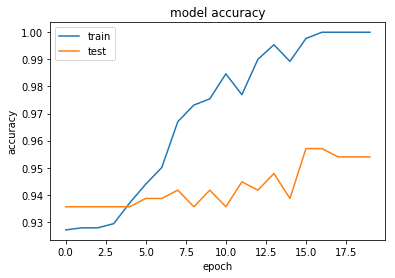

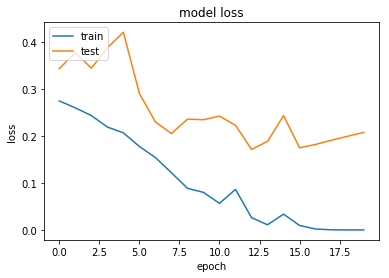

In [159]:
VeDoThiTraining(historyVanillaF)

In [160]:
vanilla3dF.save('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/vanilla3dF.h5')

In [ ]:
#from keras.models import load_model
#model1=load_model('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/vanilla3dF.h5')

In [161]:
def inceptionlayer(prev):
    tower_1 = Conv3D(64, (1,1,1), padding='same', activation='relu')(prev)
    tower_1 = Conv3D(64, (3,3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv3D(64, (1,1,1), padding='same', activation='relu')(prev)
    tower_2 = Conv3D(64, (5,5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling3D((3,3,3), strides=(1,1,1), padding='same')(prev)
    tower_3 = Conv3D(64, (1,1,1), padding='same', activation='relu')(tower_3)
    output = k.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [162]:
#GOOGLENET
def makegooglenet():
    x    = Input(shape=(64,64,64,1))
    conv1= Conv3D(32,kernel_size=(7,7,7),activation='relu')(x)
    conv1= Dropout(0.3)(conv1)
    max1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2= Conv3D(32,kernel_size=(3,3,3),activation='relu')(max1)
    conv2= Dropout(0.3)(conv2)
    max2 = MaxPooling3D(pool_size=(2,2,2))(conv2)
    incp1= inceptionlayer(max2)
    incp1= Dropout(0.3)(incp1)
    incp2= inceptionlayer(incp1)
    incp2= Dropout(0.3)(incp2)
    max3 = MaxPooling3D(pool_size=(2,2,2))(incp2)
    incp3= inceptionlayer(max3)
    incp3= Dropout(0.3)(incp3)
    incp4= inceptionlayer(incp3)
    incp4= Dropout(0.3)(incp4)
    max4 = MaxPooling3D(pool_size=(2,2,2))(incp4)
    incp5= inceptionlayer(max4)
    incp5= Dropout(0.3)(incp5)
    incp6= inceptionlayer(incp5)
    incp6= Dropout(0.3)(incp6)
    avg1= AveragePooling3D(pool_size=(2,2,2))(incp4)

    flat = Flatten()(avg1)
    flat= Dropout(0.3)(flat)
    dense= Dense(2,activation="softmax")(flat)

    googlenet = Model(inputs=x, outputs=dense)
    
    googlenet.compile(loss=k.losses.categorical_crossentropy,
              optimizer=k.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
    
    return googlenet

In [163]:
googlenetF = makegooglenet()
googlenetF.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 64, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_51 (Conv3D)              (None, 58, 58, 58, 3 11008       input_8[0][0]                    
__________________________________________________________________________________________________
dropout_54 (Dropout)            (None, 58, 58, 58, 3 0           conv3d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_36 (MaxPooling3D) (None, 29, 29, 29, 3 0           dropout_54[0][0]                 
__________________________________________________________________________________________________
conv3d_52 

__________________________________________________________________________________________________
conv3d_72 (Conv3D)              (None, 6, 6, 174, 64 4160        max_pooling3d_42[0][0]           
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 6, 6, 522, 64 0           conv3d_69[0][0]                  
                                                                 conv3d_71[0][0]                  
                                                                 conv3d_72[0][0]                  
__________________________________________________________________________________________________
dropout_59 (Dropout)            (None, 6, 6, 522, 64 0           concatenate_4[0][0]              
__________________________________________________________________________________________________
average_pooling3d_8 (AveragePoo (None, 3, 3, 261, 64 0           dropout_59[0][0]                 
__________

In [164]:
historyGoogleF= googlenetF.fit(X_trainF,y_trainF, batch_size=10, epochs=10, verbose=1, validation_data=(X_testF, y_testF))

Train on 1302 samples, validate on 326 samples
Epoch 1/10
1302/1302 [==============================] - ETA: 17:16 - loss: 0.9282 - acc: 0.0000e+ - ETA: 9:28 - loss: 0.4641 - acc: 0.5000     - ETA: 6:51 - loss: 0.3094 - acc: 0.666 - ETA: 5:33 - loss: 0.2320 - acc: 0.750 - ETA: 4:45 - loss: 0.5080 - acc: 0.780 - ETA: 4:13 - loss: 0.4233 - acc: 0.816 - ETA: 3:50 - loss: 0.3629 - acc: 0.842 - ETA: 3:32 - loss: 0.3175 - acc: 0.862 - ETA: 3:18 - loss: 0.4613 - acc: 0.866 - ETA: 3:07 - loss: 0.5764 - acc: 0.870 - ETA: 2:57 - loss: 0.6705 - acc: 0.872 - ETA: 2:49 - loss: 0.7489 - acc: 0.875 - ETA: 2:43 - loss: 0.8153 - acc: 0.876 - ETA: 2:37 - loss: 0.9873 - acc: 0.871 - ETA: 2:32 - loss: 1.0290 - acc: 0.873 - ETA: 2:27 - loss: 0.9647 - acc: 0.881 - ETA: 2:23 - loss: 0.9079 - acc: 0.888 - ETA: 2:19 - loss: 0.8575 - acc: 0.894 - ETA: 2:15 - loss: 0.8972 - acc: 0.894 - ETA: 2:12 - loss: 1.0135 - acc: 0.890 - ETA: 2:09 - loss: 1.0420 - acc: 0.890 - ETA: 2:06 - loss: 0.9946 - acc: 0.895 - ETA: 2:0

1302/1302 [==============================] - ETA: 1:52 - loss: 3.2236 - acc: 0.800 - ETA: 1:51 - loss: 1.6118 - acc: 0.900 - ETA: 1:49 - loss: 2.1491 - acc: 0.866 - ETA: 1:48 - loss: 2.4177 - acc: 0.850 - ETA: 1:47 - loss: 1.9342 - acc: 0.880 - ETA: 1:46 - loss: 2.1491 - acc: 0.866 - ETA: 1:45 - loss: 1.8421 - acc: 0.885 - ETA: 1:44 - loss: 1.6118 - acc: 0.900 - ETA: 1:43 - loss: 1.6118 - acc: 0.900 - ETA: 1:42 - loss: 1.4506 - acc: 0.910 - ETA: 1:41 - loss: 1.4653 - acc: 0.909 - ETA: 1:40 - loss: 1.4775 - acc: 0.908 - ETA: 1:39 - loss: 1.4878 - acc: 0.907 - ETA: 1:38 - loss: 1.3816 - acc: 0.914 - ETA: 1:37 - loss: 1.2894 - acc: 0.920 - ETA: 1:36 - loss: 1.2089 - acc: 0.925 - ETA: 1:35 - loss: 1.2326 - acc: 0.923 - ETA: 1:34 - loss: 1.1641 - acc: 0.927 - ETA: 1:33 - loss: 1.1028 - acc: 0.931 - ETA: 1:33 - loss: 1.2089 - acc: 0.925 - ETA: 1:32 - loss: 1.1513 - acc: 0.928 - ETA: 1:31 - loss: 1.0990 - acc: 0.931 - ETA: 1:30 - loss: 1.0512 - acc: 0.934 - ETA: 1:29 - loss: 1.0074 - acc: 0.9

1302/1302 [==============================] - ETA: 1:51 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:48 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:47 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:46 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:45 - loss: 0.6447 - acc: 0.9600    - ETA: 1:44 - loss: 0.5373 - acc: 0.966 - ETA: 1:43 - loss: 0.9210 - acc: 0.942 - ETA: 1:44 - loss: 0.8059 - acc: 0.950 - ETA: 1:43 - loss: 0.8954 - acc: 0.944 - ETA: 1:42 - loss: 0.8059 - acc: 0.950 - ETA: 1:41 - loss: 0.7326 - acc: 0.954 - ETA: 1:40 - loss: 0.6716 - acc: 0.958 - ETA: 1:39 - loss: 0.7439 - acc: 0.953 - ETA: 1:39 - loss: 0.6908 - acc: 0.957 - ETA: 1:38 - loss: 0.6447 - acc: 0.960 - ETA: 1:37 - loss: 0.6044 - acc: 0.962 - ETA: 1:36 - loss: 0.5689 - acc: 0.964 - ETA: 1:35 - loss: 0.6268 - acc: 0.961 - ETA: 1:34 - loss: 0.5938 - acc: 0.963 - ETA: 1:34 - loss: 0.5641 - acc: 0.965 - ETA: 1:33 - loss: 0.6908 - acc: 0.957 - ETA: 1:32 - loss: 0.6594 - acc: 0.959 - ETA: 1:31 - loss: 0.7008 - acc: 0.956 - ETA: 1:30 - los

1302/1302 [==============================] - ETA: 1:51 - loss: 4.8354 - acc: 0.700 - ETA: 1:50 - loss: 2.4177 - acc: 0.850 - ETA: 1:48 - loss: 2.6863 - acc: 0.833 - ETA: 1:47 - loss: 2.4177 - acc: 0.850 - ETA: 1:46 - loss: 2.5789 - acc: 0.840 - ETA: 1:46 - loss: 2.4177 - acc: 0.850 - ETA: 1:45 - loss: 2.0723 - acc: 0.871 - ETA: 1:44 - loss: 2.0148 - acc: 0.875 - ETA: 1:43 - loss: 1.7909 - acc: 0.888 - ETA: 1:42 - loss: 1.6118 - acc: 0.900 - ETA: 1:41 - loss: 1.4653 - acc: 0.909 - ETA: 1:40 - loss: 1.4775 - acc: 0.908 - ETA: 1:39 - loss: 1.4878 - acc: 0.907 - ETA: 1:38 - loss: 1.6118 - acc: 0.900 - ETA: 1:37 - loss: 1.5044 - acc: 0.906 - ETA: 1:37 - loss: 1.5111 - acc: 0.906 - ETA: 1:36 - loss: 1.4222 - acc: 0.911 - ETA: 1:35 - loss: 1.3432 - acc: 0.916 - ETA: 1:34 - loss: 1.2725 - acc: 0.921 - ETA: 1:33 - loss: 1.2089 - acc: 0.925 - ETA: 1:32 - loss: 1.1513 - acc: 0.928 - ETA: 1:32 - loss: 1.0990 - acc: 0.931 - ETA: 1:31 - loss: 1.0512 - acc: 0.934 - ETA: 1:30 - loss: 1.0074 - acc: 0.9

1302/1302 [==============================] - ETA: 1:49 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:48 - loss: 1.6118 - acc: 0.9000    - ETA: 1:47 - loss: 1.6118 - acc: 0.900 - ETA: 1:49 - loss: 1.2089 - acc: 0.925 - ETA: 1:47 - loss: 0.9671 - acc: 0.940 - ETA: 1:47 - loss: 0.8059 - acc: 0.950 - ETA: 1:45 - loss: 0.9210 - acc: 0.942 - ETA: 1:44 - loss: 1.0074 - acc: 0.937 - ETA: 1:43 - loss: 0.8954 - acc: 0.944 - ETA: 1:42 - loss: 0.8059 - acc: 0.950 - ETA: 1:41 - loss: 0.7326 - acc: 0.954 - ETA: 1:40 - loss: 0.8059 - acc: 0.950 - ETA: 1:39 - loss: 0.7439 - acc: 0.953 - ETA: 1:38 - loss: 0.9210 - acc: 0.942 - ETA: 1:37 - loss: 0.8596 - acc: 0.946 - ETA: 1:37 - loss: 1.0074 - acc: 0.937 - ETA: 1:36 - loss: 0.9481 - acc: 0.941 - ETA: 1:35 - loss: 0.8954 - acc: 0.944 - ETA: 1:34 - loss: 0.8483 - acc: 0.947 - ETA: 1:33 - loss: 0.8059 - acc: 0.950 - ETA: 1:33 - loss: 0.7675 - acc: 0.952 - ETA: 1:32 - loss: 0.7326 - acc: 0.954 - ETA: 1:31 - loss: 0.7008 - acc: 0.956 - ETA: 1:30 - loss: 0.6716 - 

1302/1302 [==============================] - ETA: 1:50 - loss: 1.6118 - acc: 0.900 - ETA: 1:49 - loss: 0.8059 - acc: 0.950 - ETA: 1:48 - loss: 1.0745 - acc: 0.933 - ETA: 1:47 - loss: 1.2089 - acc: 0.925 - ETA: 1:47 - loss: 1.6118 - acc: 0.900 - ETA: 1:45 - loss: 2.1491 - acc: 0.866 - ETA: 1:44 - loss: 1.8421 - acc: 0.885 - ETA: 1:44 - loss: 1.8133 - acc: 0.887 - ETA: 1:43 - loss: 1.7909 - acc: 0.888 - ETA: 1:42 - loss: 1.6118 - acc: 0.900 - ETA: 1:41 - loss: 1.6118 - acc: 0.900 - ETA: 1:40 - loss: 1.7461 - acc: 0.891 - ETA: 1:40 - loss: 1.6118 - acc: 0.900 - ETA: 1:39 - loss: 1.4967 - acc: 0.907 - ETA: 1:38 - loss: 1.6118 - acc: 0.900 - ETA: 1:37 - loss: 1.5111 - acc: 0.906 - ETA: 1:36 - loss: 1.4222 - acc: 0.911 - ETA: 1:35 - loss: 1.4327 - acc: 0.911 - ETA: 1:34 - loss: 1.4421 - acc: 0.910 - ETA: 1:33 - loss: 1.3700 - acc: 0.915 - ETA: 1:32 - loss: 1.3048 - acc: 0.919 - ETA: 1:32 - loss: 1.3188 - acc: 0.918 - ETA: 1:31 - loss: 1.3315 - acc: 0.917 - ETA: 1:30 - loss: 1.3432 - acc: 0.9

1302/1302 [==============================] - ETA: 1:47 - loss: 1.6118 - acc: 0.900 - ETA: 1:47 - loss: 3.2236 - acc: 0.800 - ETA: 1:46 - loss: 2.6863 - acc: 0.833 - ETA: 1:45 - loss: 2.4177 - acc: 0.850 - ETA: 1:45 - loss: 1.9342 - acc: 0.880 - ETA: 1:44 - loss: 1.6118 - acc: 0.900 - ETA: 1:43 - loss: 1.3816 - acc: 0.914 - ETA: 1:42 - loss: 1.2089 - acc: 0.925 - ETA: 1:41 - loss: 1.2536 - acc: 0.922 - ETA: 1:41 - loss: 1.2894 - acc: 0.920 - ETA: 1:40 - loss: 1.4653 - acc: 0.909 - ETA: 1:39 - loss: 1.3432 - acc: 0.916 - ETA: 1:38 - loss: 1.2399 - acc: 0.923 - ETA: 1:37 - loss: 1.1513 - acc: 0.928 - ETA: 1:37 - loss: 1.0745 - acc: 0.933 - ETA: 1:36 - loss: 1.0074 - acc: 0.937 - ETA: 1:35 - loss: 0.9481 - acc: 0.941 - ETA: 1:34 - loss: 0.8954 - acc: 0.944 - ETA: 1:34 - loss: 1.0180 - acc: 0.936 - ETA: 1:33 - loss: 0.9671 - acc: 0.940 - ETA: 1:32 - loss: 0.9978 - acc: 0.938 - ETA: 1:31 - loss: 1.0990 - acc: 0.931 - ETA: 1:30 - loss: 1.1213 - acc: 0.930 - ETA: 1:29 - loss: 1.0745 - acc: 0.9

1302/1302 [==============================] - ETA: 1:50 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:49 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:48 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:49 - loss: 0.8059 - acc: 0.9500    - ETA: 1:48 - loss: 0.6447 - acc: 0.960 - ETA: 1:46 - loss: 0.8059 - acc: 0.950 - ETA: 1:45 - loss: 1.1513 - acc: 0.928 - ETA: 1:44 - loss: 1.0074 - acc: 0.937 - ETA: 1:43 - loss: 1.0745 - acc: 0.933 - ETA: 1:43 - loss: 1.1283 - acc: 0.930 - ETA: 1:42 - loss: 1.0257 - acc: 0.936 - ETA: 1:41 - loss: 1.0745 - acc: 0.933 - ETA: 1:40 - loss: 0.9919 - acc: 0.938 - ETA: 1:39 - loss: 1.1513 - acc: 0.928 - ETA: 1:38 - loss: 1.0745 - acc: 0.933 - ETA: 1:37 - loss: 1.1081 - acc: 0.931 - ETA: 1:36 - loss: 1.0429 - acc: 0.935 - ETA: 1:35 - loss: 1.1641 - acc: 0.927 - ETA: 1:35 - loss: 1.1028 - acc: 0.931 - ETA: 1:34 - loss: 1.1283 - acc: 0.930 - ETA: 1:33 - loss: 1.1513 - acc: 0.928 - ETA: 1:32 - loss: 1.0990 - acc: 0.931 - ETA: 1:31 - loss: 1.1213 - acc: 0.930 - ETA: 1:30 - loss: 1

1302/1302 [==============================] - ETA: 1:48 - loss: 1.1921e-07 - acc: 1.000 - ETA: 1:49 - loss: 0.8059 - acc: 0.9500    - ETA: 1:48 - loss: 1.6118 - acc: 0.900 - ETA: 1:47 - loss: 1.2089 - acc: 0.925 - ETA: 1:47 - loss: 1.6118 - acc: 0.900 - ETA: 1:46 - loss: 1.8804 - acc: 0.883 - ETA: 1:45 - loss: 1.6118 - acc: 0.900 - ETA: 1:44 - loss: 1.6118 - acc: 0.900 - ETA: 1:43 - loss: 1.6118 - acc: 0.900 - ETA: 1:43 - loss: 1.4506 - acc: 0.910 - ETA: 1:42 - loss: 1.4653 - acc: 0.909 - ETA: 1:41 - loss: 1.3432 - acc: 0.916 - ETA: 1:40 - loss: 1.2399 - acc: 0.923 - ETA: 1:39 - loss: 1.2664 - acc: 0.921 - ETA: 1:38 - loss: 1.1820 - acc: 0.926 - ETA: 1:37 - loss: 1.1081 - acc: 0.931 - ETA: 1:37 - loss: 1.0429 - acc: 0.935 - ETA: 1:36 - loss: 0.9850 - acc: 0.938 - ETA: 1:35 - loss: 0.9332 - acc: 0.942 - ETA: 1:34 - loss: 0.8865 - acc: 0.945 - ETA: 1:33 - loss: 0.9210 - acc: 0.942 - ETA: 1:32 - loss: 0.8792 - acc: 0.945 - ETA: 1:31 - loss: 0.9110 - acc: 0.943 - ETA: 1:31 - loss: 0.9402 - 

1302/1302 [==============================] - ETA: 1:49 - loss: 1.6118 - acc: 0.900 - ETA: 1:48 - loss: 1.6118 - acc: 0.900 - ETA: 1:48 - loss: 1.0745 - acc: 0.933 - ETA: 1:47 - loss: 1.2089 - acc: 0.925 - ETA: 1:46 - loss: 1.6118 - acc: 0.900 - ETA: 1:45 - loss: 1.6118 - acc: 0.900 - ETA: 1:44 - loss: 1.6118 - acc: 0.900 - ETA: 1:43 - loss: 1.6118 - acc: 0.900 - ETA: 1:43 - loss: 1.6118 - acc: 0.900 - ETA: 1:42 - loss: 1.4506 - acc: 0.910 - ETA: 1:41 - loss: 1.3188 - acc: 0.918 - ETA: 1:40 - loss: 1.2089 - acc: 0.925 - ETA: 1:40 - loss: 1.1159 - acc: 0.930 - ETA: 1:39 - loss: 1.0362 - acc: 0.935 - ETA: 1:38 - loss: 1.1820 - acc: 0.926 - ETA: 1:37 - loss: 1.1081 - acc: 0.931 - ETA: 1:36 - loss: 1.0429 - acc: 0.935 - ETA: 1:35 - loss: 1.0745 - acc: 0.933 - ETA: 1:34 - loss: 1.1028 - acc: 0.931 - ETA: 1:34 - loss: 1.0477 - acc: 0.935 - ETA: 1:33 - loss: 0.9978 - acc: 0.938 - ETA: 1:32 - loss: 1.0257 - acc: 0.936 - ETA: 1:31 - loss: 0.9811 - acc: 0.939 - ETA: 1:30 - loss: 0.9402 - acc: 0.9

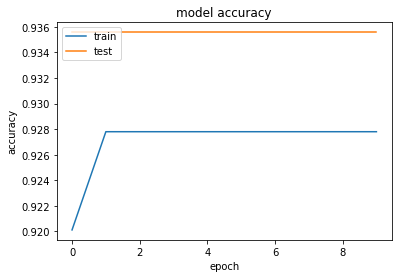

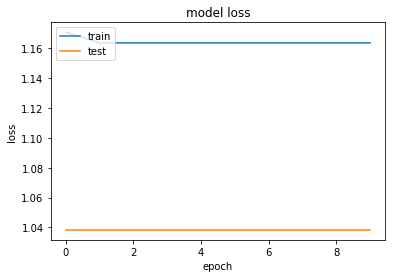

In [165]:
VeDoThiTraining(historyGoogleF)

In [166]:
googlenetF.save('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/OutputSubset0/googlenetF.h5')

In [189]:
predicted = googlenetF.predict(X_testF[:])
pre = np.argmax(predicted,axis=1)
tru = np.argmax(y_testF[:],axis=1)

In [190]:
from sklearn.metrics import classification_report

In [191]:
print(classification_report(tru,pre))

C:\Users\vuong.huynh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        21
          1       0.94      1.00      0.97       305

avg / total       0.88      0.94      0.90       326



## 2.2 Xử lý trên Full data 

In [148]:
outdir_noduleFull = 'D:/Lung cancer/nodule/'
outdir_non_noduleFull = 'D:/Lung cancer/non-nodule/'

In [149]:
count1=0
from glob import glob
for cand in tqdm(cands.values):
    path = glob('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset*/'+cand[0]+".mhd")
    if len(path)>0:
        if cand[4]==1:
            numpyImage, numpyOrigin, numpySpacing = load_itk_image(path[0])
            worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
            voxelWidth = 64
            patch = numpyImage[int(voxelCoord[0]-voxelWidth/2):int(voxelCoord[0]+voxelWidth/2),int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2),int(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2)]
            patch = normalizePlanes(patch)

            desired= cand[4]
            
            if(desired==0):
                yy = [0,1]
            else:
                yy= [1,0]

            np.save(outdir_noduleFull+str(count1)+"1X.npy",patch)
            np.save(outdir_non_noduleFull+str(count1)+"1Y.npy",yy)
            
            count1 = count1 +1
                
print(count1)




  0%|                                                                                       | 0/551065 [00:00<?, ?it/s]


  0%|                                                                            | 1/551065 [00:00<17:15:02,  8.87it/s]


  0%|                                                                           | 14/551065 [00:01<21:08:22,  7.24it/s]


  0%|                                                                            | 79/551065 [00:02<4:19:38, 35.37it/s]


  0%|                                                                           | 202/551065 [00:02<1:46:14, 86.42it/s]


  0%|                                                                          | 318/551065 [00:02<1:10:24, 130.38it/s]


  0%|                                                                            | 424/551065 [00:02<54:58, 166.94it/s]


  0%|                                                                            | 542/551065 [00:02<44:49, 204.72it/s]


  0%|                

  3%|██▎                                                                       | 17580/551065 [00:48<24:33, 362.04it/s]


  3%|██▍                                                                       | 17717/551065 [00:48<24:24, 364.11it/s]


  3%|██▍                                                                       | 17852/551065 [00:48<24:16, 366.12it/s]


  3%|██▍                                                                       | 17994/551065 [00:48<24:07, 368.27it/s]


  3%|██▍                                                                       | 18140/551065 [00:48<23:58, 370.49it/s]


  3%|██▍                                                                       | 18289/551065 [00:49<23:49, 372.77it/s]


  3%|██▍                                                                       | 18459/551065 [00:49<23:38, 375.46it/s]


  3%|██▌                                                                       | 18633/551065 [00:49<23:27, 378.23it/s]


  3%|██▌                

  7%|████▊                                                                     | 35920/551065 [02:08<30:46, 279.02it/s]


  7%|████▊                                                                     | 36023/551065 [02:10<31:12, 274.99it/s]


  7%|████▊                                                                     | 36158/551065 [02:11<31:06, 275.81it/s]


  7%|████▊                                                                     | 36250/551065 [02:11<31:06, 275.78it/s]


  7%|████▉                                                                     | 36392/551065 [02:11<31:00, 276.64it/s]


  7%|████▉                                                                     | 36522/551065 [02:11<30:54, 277.42it/s]


  7%|████▉                                                                     | 36688/551065 [02:11<30:47, 278.47it/s]


  7%|████▉                                                                     | 36847/551065 [02:11<30:40, 279.46it/s]


  7%|████▉              

 10%|███████▏                                                                  | 53553/551065 [03:15<30:11, 274.61it/s]


 10%|███████▏                                                                  | 53698/551065 [03:15<30:07, 275.21it/s]


 10%|███████▏                                                                  | 53798/551065 [03:15<30:04, 275.58it/s]


 10%|███████▏                                                                  | 53925/551065 [03:15<30:00, 276.09it/s]


 10%|███████▎                                                                  | 54064/551065 [03:15<29:56, 276.66it/s]


 10%|███████▎                                                                  | 54181/551065 [03:18<30:24, 272.34it/s]


 10%|███████▎                                                                  | 54312/551065 [03:19<30:20, 272.86it/s]


 10%|███████▎                                                                  | 54458/551065 [03:19<30:16, 273.45it/s]


 10%|███████▎           

 13%|█████████▍                                                                | 70213/551065 [04:07<28:11, 284.24it/s]


 13%|█████████▍                                                                | 70332/551065 [04:07<28:11, 284.28it/s]


 13%|█████████▍                                                                | 70458/551065 [04:12<28:44, 278.72it/s]


 13%|█████████▍                                                                | 70611/551065 [04:12<28:40, 279.22it/s]


 13%|█████████▌                                                                | 70753/551065 [04:12<28:37, 279.67it/s]


 13%|█████████▌                                                                | 70896/551065 [04:13<28:34, 280.12it/s]


 13%|█████████▌                                                                | 71042/551065 [04:13<28:30, 280.58it/s]


 13%|█████████▌                                                                | 71181/551065 [04:13<28:27, 281.02it/s]


 13%|█████████▌         

 16%|███████████▋                                                              | 87140/551065 [05:01<26:44, 289.15it/s]


 16%|███████████▋                                                              | 87289/551065 [05:01<26:41, 289.54it/s]


 16%|███████████▋                                                              | 87425/551065 [05:01<26:39, 289.90it/s]


 16%|███████████▊                                                              | 87574/551065 [05:01<26:36, 290.29it/s]


 16%|███████████▊                                                              | 87731/551065 [05:01<26:33, 290.72it/s]


 16%|███████████▊                                                              | 87873/551065 [05:01<26:31, 291.09it/s]


 16%|███████████▊                                                              | 88012/551065 [05:01<26:28, 291.43it/s]


 16%|███████████▊                                                              | 88143/551065 [05:02<26:26, 291.77it/s]


 16%|███████████▊       

 19%|█████████████▌                                                           | 102568/551065 [06:11<27:05, 275.95it/s]


 19%|█████████████▌                                                           | 102704/551065 [06:11<27:03, 276.24it/s]


 19%|█████████████▌                                                           | 102842/551065 [06:11<27:00, 276.53it/s]


 19%|█████████████▋                                                           | 102978/551065 [06:11<26:58, 276.82it/s]


 19%|█████████████▋                                                           | 103107/551065 [06:12<26:56, 277.10it/s]


 19%|█████████████▋                                                           | 103225/551065 [06:12<26:54, 277.34it/s]


 19%|█████████████▋                                                           | 103342/551065 [06:12<26:53, 277.57it/s]


 19%|█████████████▋                                                           | 103455/551065 [06:12<26:51, 277.78it/s]


 19%|█████████████▋     

 22%|███████████████▊                                                         | 119317/551065 [07:01<25:26, 282.91it/s]


 22%|███████████████▊                                                         | 119404/551065 [07:02<25:26, 282.78it/s]


 22%|███████████████▊                                                         | 119515/551065 [07:02<25:25, 282.97it/s]


 22%|███████████████▊                                                         | 119619/551065 [07:02<25:23, 283.15it/s]


 22%|███████████████▊                                                         | 119748/551065 [07:02<25:21, 283.39it/s]


 22%|███████████████▉                                                         | 119864/551065 [07:02<25:20, 283.60it/s]


 22%|███████████████▉                                                         | 119992/551065 [07:02<25:18, 283.83it/s]


 22%|███████████████▉                                                         | 120116/551065 [07:02<25:17, 284.06it/s]


 22%|███████████████▉   

 24%|█████████████████▉                                                       | 134997/551065 [08:15<25:28, 272.27it/s]


 25%|█████████████████▉                                                       | 135153/551065 [08:15<25:26, 272.53it/s]


 25%|█████████████████▉                                                       | 135290/551065 [08:17<25:28, 272.09it/s]


 25%|█████████████████▉                                                       | 135401/551065 [08:17<25:26, 272.26it/s]


 25%|█████████████████▉                                                       | 135520/551065 [08:17<25:25, 272.44it/s]


 25%|█████████████████▉                                                       | 135665/551065 [08:17<25:23, 272.68it/s]


 25%|█████████████████▉                                                       | 135827/551065 [08:17<25:21, 272.95it/s]


 25%|██████████████████                                                       | 135963/551065 [08:17<25:19, 273.16it/s]


 25%|██████████████████ 

 27%|███████████████████▉                                                     | 150801/551065 [09:11<24:23, 273.44it/s]


 27%|███████████████████▉                                                     | 150941/551065 [09:11<24:22, 273.64it/s]


 27%|████████████████████                                                     | 151088/551065 [09:11<24:20, 273.86it/s]


 27%|████████████████████                                                     | 151207/551065 [09:11<24:19, 274.02it/s]


 27%|████████████████████                                                     | 151326/551065 [09:11<24:17, 274.18it/s]


 27%|████████████████████                                                     | 151460/551065 [09:12<24:16, 274.38it/s]


 28%|████████████████████                                                     | 151581/551065 [09:12<24:15, 274.53it/s]


 28%|████████████████████                                                     | 151702/551065 [09:12<24:13, 274.70it/s]


 28%|███████████████████

 30%|██████████████████████                                                   | 166142/551065 [10:08<23:30, 272.91it/s]


 30%|██████████████████████                                                   | 166225/551065 [10:09<23:30, 272.75it/s]


 30%|██████████████████████                                                   | 166346/551065 [10:09<23:29, 272.90it/s]


 30%|██████████████████████                                                   | 166481/551065 [10:09<23:28, 273.08it/s]


 30%|██████████████████████                                                   | 166607/551065 [10:11<23:31, 272.36it/s]


 30%|██████████████████████                                                   | 166743/551065 [10:11<23:30, 272.53it/s]


 30%|██████████████████████                                                   | 166849/551065 [10:11<23:29, 272.66it/s]


 30%|██████████████████████                                                   | 166991/551065 [10:12<23:27, 272.85it/s]


 30%|███████████████████

 33%|████████████████████████▏                                                | 182211/551065 [11:10<22:37, 271.72it/s]


 33%|████████████████████████▏                                                | 182349/551065 [11:10<22:36, 271.88it/s]


 33%|████████████████████████▏                                                | 182461/551065 [11:14<22:42, 270.56it/s]


 33%|████████████████████████▏                                                | 182591/551065 [11:14<22:41, 270.71it/s]


 33%|████████████████████████▏                                                | 182721/551065 [11:14<22:39, 270.86it/s]


 33%|████████████████████████▏                                                | 182826/551065 [11:16<22:43, 270.11it/s]


 33%|████████████████████████▏                                                | 182901/551065 [11:17<22:43, 270.06it/s]


 33%|████████████████████████▏                                                | 183011/551065 [11:17<22:42, 270.18it/s]


 33%|███████████████████

 36%|██████████████████████████▏                                              | 197597/551065 [12:09<21:44, 270.95it/s]


 36%|██████████████████████████▏                                              | 197714/551065 [12:09<21:43, 271.07it/s]


 36%|██████████████████████████▏                                              | 197830/551065 [12:09<21:42, 271.19it/s]


 36%|██████████████████████████▏                                              | 197946/551065 [12:12<21:46, 270.33it/s]


 36%|██████████████████████████▏                                              | 198069/551065 [12:12<21:45, 270.32it/s]


 36%|██████████████████████████▏                                              | 198135/551065 [12:12<21:45, 270.37it/s]


 36%|██████████████████████████▎                                              | 198275/551065 [12:12<21:44, 270.53it/s]


 36%|██████████████████████████▎                                              | 198407/551065 [12:13<21:42, 270.67it/s]


 36%|███████████████████

 39%|████████████████████████████▏                                            | 213118/551065 [13:15<21:01, 267.81it/s]


 39%|████████████████████████████▏                                            | 213245/551065 [13:15<21:00, 267.94it/s]


 39%|████████████████████████████▎                                            | 213370/551065 [13:15<20:59, 268.06it/s]


 39%|████████████████████████████▎                                            | 213491/551065 [13:16<20:58, 268.17it/s]


 39%|████████████████████████████▎                                            | 213608/551065 [13:16<20:57, 268.28it/s]


 39%|████████████████████████████▎                                            | 213736/551065 [13:16<20:56, 268.41it/s]


 39%|████████████████████████████▎                                            | 213868/551065 [13:16<20:55, 268.54it/s]


 39%|████████████████████████████▎                                            | 214008/551065 [13:16<20:54, 268.68it/s]


 39%|███████████████████

 42%|██████████████████████████████▍                                          | 229403/551065 [14:11<19:53, 269.53it/s]


 42%|██████████████████████████████▍                                          | 229527/551065 [14:11<19:52, 269.64it/s]


 42%|██████████████████████████████▍                                          | 229640/551065 [14:15<19:57, 268.34it/s]


 42%|██████████████████████████████▍                                          | 229766/551065 [14:15<19:56, 268.45it/s]


 42%|██████████████████████████████▍                                          | 229868/551065 [14:16<19:56, 268.34it/s]


 42%|██████████████████████████████▍                                          | 230001/551065 [14:16<19:55, 268.46it/s]


 42%|██████████████████████████████▍                                          | 230109/551065 [14:17<19:55, 268.36it/s]


 42%|██████████████████████████████▍                                          | 230221/551065 [14:17<19:55, 268.46it/s]


 42%|███████████████████

 44%|████████████████████████████████▍                                        | 245185/551065 [15:14<19:00, 268.16it/s]


 45%|████████████████████████████████▍                                        | 245304/551065 [15:14<18:59, 268.26it/s]


 45%|████████████████████████████████▌                                        | 245424/551065 [15:14<18:58, 268.36it/s]


 45%|████████████████████████████████▌                                        | 245549/551065 [15:14<18:58, 268.47it/s]


 45%|████████████████████████████████▌                                        | 245684/551065 [15:14<18:56, 268.59it/s]


 45%|████████████████████████████████▌                                        | 245809/551065 [15:14<18:56, 268.69it/s]


 45%|████████████████████████████████▌                                        | 245951/551065 [15:14<18:55, 268.82it/s]


 45%|████████████████████████████████▌                                        | 246086/551065 [15:15<18:54, 268.93it/s]


 45%|███████████████████

 47%|██████████████████████████████████▋                                      | 261607/551065 [16:04<17:46, 271.29it/s]


 47%|██████████████████████████████████▋                                      | 261727/551065 [16:04<17:46, 271.39it/s]


 48%|██████████████████████████████████▋                                      | 261842/551065 [16:04<17:45, 271.48it/s]


 48%|██████████████████████████████████▋                                      | 261955/551065 [16:04<17:44, 271.57it/s]


 48%|██████████████████████████████████▋                                      | 262054/551065 [16:07<17:46, 270.96it/s]


 48%|██████████████████████████████████▋                                      | 262177/551065 [16:07<17:45, 271.06it/s]


 48%|██████████████████████████████████▋                                      | 262263/551065 [16:11<17:49, 270.07it/s]


 48%|██████████████████████████████████▊                                      | 262416/551065 [16:11<17:48, 270.20it/s]


 48%|███████████████████

 50%|████████████████████████████████████▋                                    | 276932/551065 [17:21<17:10, 266.01it/s]


 50%|████████████████████████████████████▋                                    | 277015/551065 [17:25<17:14, 264.96it/s]


 50%|████████████████████████████████████▋                                    | 277153/551065 [17:25<17:13, 265.06it/s]


 50%|████████████████████████████████████▋                                    | 277279/551065 [17:25<17:12, 265.16it/s]


 50%|████████████████████████████████████▋                                    | 277374/551065 [17:27<17:13, 264.77it/s]


 50%|████████████████████████████████████▊                                    | 277442/551065 [17:28<17:13, 264.70it/s]


 50%|████████████████████████████████████▊                                    | 277547/551065 [17:28<17:13, 264.77it/s]


 50%|████████████████████████████████████▊                                    | 277615/551065 [17:28<17:12, 264.73it/s]


 50%|███████████████████

 53%|██████████████████████████████████████▊                                  | 293222/551065 [18:24<16:11, 265.46it/s]


 53%|██████████████████████████████████████▊                                  | 293329/551065 [18:24<16:10, 265.53it/s]


 53%|██████████████████████████████████████▊                                  | 293440/551065 [18:24<16:09, 265.61it/s]


 53%|██████████████████████████████████████▉                                  | 293571/551065 [18:24<16:09, 265.70it/s]


 53%|██████████████████████████████████████▉                                  | 293683/551065 [18:25<16:08, 265.77it/s]


 53%|██████████████████████████████████████▉                                  | 293812/551065 [18:25<16:07, 265.86it/s]


 53%|██████████████████████████████████████▉                                  | 293948/551065 [18:25<16:06, 265.96it/s]


 53%|██████████████████████████████████████▉                                  | 294066/551065 [18:26<16:06, 265.78it/s]


 53%|███████████████████

 56%|█████████████████████████████████████████                                | 309517/551065 [19:35<15:17, 263.37it/s]


 56%|█████████████████████████████████████████                                | 309585/551065 [19:35<15:16, 263.37it/s]


 56%|█████████████████████████████████████████                                | 309702/551065 [19:35<15:16, 263.45it/s]


 56%|█████████████████████████████████████████                                | 309776/551065 [19:38<15:17, 262.97it/s]


 56%|█████████████████████████████████████████                                | 309908/551065 [19:38<15:16, 263.06it/s]


 56%|█████████████████████████████████████████                                | 309985/551065 [19:38<15:16, 263.10it/s]


 56%|█████████████████████████████████████████                                | 310060/551065 [19:39<15:16, 262.89it/s]


 56%|█████████████████████████████████████████                                | 310114/551065 [19:39<15:16, 262.87it/s]


 56%|███████████████████

 59%|██████████████████████████████████████████▉                              | 324594/551065 [20:44<14:28, 260.86it/s]


 59%|███████████████████████████████████████████                              | 324629/551065 [20:44<14:28, 260.79it/s]


 59%|███████████████████████████████████████████                              | 324657/551065 [20:45<14:28, 260.71it/s]


 59%|███████████████████████████████████████████                              | 324678/551065 [20:45<14:28, 260.62it/s]


 59%|███████████████████████████████████████████                              | 324726/551065 [20:46<14:29, 260.42it/s]


 59%|███████████████████████████████████████████                              | 324743/551065 [20:47<14:29, 260.38it/s]


 59%|███████████████████████████████████████████                              | 324860/551065 [20:47<14:28, 260.46it/s]


 59%|███████████████████████████████████████████                              | 324903/551065 [20:47<14:28, 260.44it/s]


 59%|███████████████████

 62%|█████████████████████████████████████████████                            | 340114/551065 [21:44<13:29, 260.68it/s]


 62%|█████████████████████████████████████████████                            | 340237/551065 [21:44<13:28, 260.76it/s]


 62%|█████████████████████████████████████████████                            | 340342/551065 [21:49<13:31, 259.83it/s]


 62%|█████████████████████████████████████████████                            | 340423/551065 [21:51<13:31, 259.61it/s]


 62%|█████████████████████████████████████████████                            | 340546/551065 [21:51<13:30, 259.69it/s]


 62%|█████████████████████████████████████████████▏                           | 340663/551065 [21:51<13:30, 259.76it/s]


 62%|█████████████████████████████████████████████▏                           | 340750/551065 [21:51<13:29, 259.77it/s]


 62%|█████████████████████████████████████████████▏                           | 340821/551065 [21:51<13:29, 259.78it/s]


 62%|███████████████████

 65%|███████████████████████████████████████████████▏                         | 355964/551065 [22:51<12:31, 259.49it/s]


 65%|███████████████████████████████████████████████▏                         | 356104/551065 [22:51<12:31, 259.57it/s]


 65%|███████████████████████████████████████████████▏                         | 356244/551065 [22:51<12:30, 259.66it/s]


 65%|███████████████████████████████████████████████▏                         | 356403/551065 [22:52<12:29, 259.75it/s]


 65%|███████████████████████████████████████████████▏                         | 356528/551065 [22:52<12:28, 259.83it/s]


 65%|███████████████████████████████████████████████▏                         | 356652/551065 [22:52<12:28, 259.89it/s]


 65%|███████████████████████████████████████████████▎                         | 356789/551065 [22:54<12:28, 259.56it/s]


 65%|███████████████████████████████████████████████▎                         | 356926/551065 [22:54<12:27, 259.64it/s]


 65%|███████████████████

 68%|█████████████████████████████████████████████████▍                       | 372759/551065 [23:39<11:19, 262.54it/s]


 68%|█████████████████████████████████████████████████▍                       | 372889/551065 [23:39<11:18, 262.61it/s]


 68%|█████████████████████████████████████████████████▍                       | 373027/551065 [23:40<11:17, 262.69it/s]


 68%|█████████████████████████████████████████████████▍                       | 373158/551065 [23:40<11:17, 262.77it/s]


 68%|█████████████████████████████████████████████████▍                       | 373283/551065 [23:40<11:16, 262.84it/s]


 68%|█████████████████████████████████████████████████▍                       | 373424/551065 [23:40<11:15, 262.92it/s]


 68%|█████████████████████████████████████████████████▍                       | 373544/551065 [23:41<11:15, 262.80it/s]


 68%|█████████████████████████████████████████████████▍                       | 373658/551065 [23:41<11:14, 262.86it/s]


 68%|███████████████████

 71%|███████████████████████████████████████████████████▌                     | 389149/551065 [24:36<10:14, 263.56it/s]


 71%|███████████████████████████████████████████████████▌                     | 389262/551065 [24:36<10:13, 263.61it/s]


 71%|███████████████████████████████████████████████████▌                     | 389391/551065 [24:36<10:13, 263.68it/s]


 71%|███████████████████████████████████████████████████▌                     | 389532/551065 [24:36<10:12, 263.76it/s]


 71%|███████████████████████████████████████████████████▌                     | 389661/551065 [24:36<10:11, 263.83it/s]


 71%|███████████████████████████████████████████████████▋                     | 389802/551065 [24:37<10:11, 263.91it/s]


 71%|███████████████████████████████████████████████████▋                     | 389954/551065 [24:37<10:10, 263.99it/s]


 71%|███████████████████████████████████████████████████▋                     | 390090/551065 [24:38<10:10, 263.87it/s]


 71%|███████████████████

 73%|█████████████████████████████████████████████████████▋                   | 405032/551065 [25:44<09:16, 262.31it/s]


 74%|█████████████████████████████████████████████████████▋                   | 405164/551065 [25:44<09:16, 262.38it/s]


 74%|█████████████████████████████████████████████████████▋                   | 405281/551065 [25:44<09:15, 262.44it/s]


 74%|█████████████████████████████████████████████████████▋                   | 405430/551065 [25:44<09:14, 262.52it/s]


 74%|█████████████████████████████████████████████████████▋                   | 405569/551065 [25:44<09:14, 262.59it/s]


 74%|█████████████████████████████████████████████████████▋                   | 405694/551065 [25:44<09:13, 262.62it/s]


 74%|█████████████████████████████████████████████████████▊                   | 405822/551065 [25:44<09:12, 262.69it/s]


 74%|█████████████████████████████████████████████████████▊                   | 405967/551065 [25:44<09:12, 262.76it/s]


 74%|███████████████████

 77%|███████████████████████████████████████████████████████▉                 | 421940/551065 [26:30<08:06, 265.25it/s]


 77%|███████████████████████████████████████████████████████▉                 | 422077/551065 [26:30<08:06, 265.32it/s]


 77%|███████████████████████████████████████████████████████▉                 | 422228/551065 [26:30<08:05, 265.40it/s]


 77%|███████████████████████████████████████████████████████▉                 | 422365/551065 [26:31<08:05, 265.32it/s]


 77%|███████████████████████████████████████████████████████▉                 | 422465/551065 [26:34<08:05, 264.91it/s]


 77%|███████████████████████████████████████████████████████▉                 | 422604/551065 [26:34<08:04, 264.98it/s]


 77%|████████████████████████████████████████████████████████                 | 422740/551065 [26:34<08:04, 265.05it/s]


 77%|████████████████████████████████████████████████████████                 | 422868/551065 [26:35<08:03, 265.11it/s]


 77%|███████████████████

 80%|██████████████████████████████████████████████████████████▏              | 438828/551065 [27:31<07:02, 265.76it/s]


 80%|██████████████████████████████████████████████████████████▏              | 438973/551065 [27:31<07:01, 265.83it/s]


 80%|██████████████████████████████████████████████████████████▏              | 439094/551065 [27:31<07:01, 265.88it/s]


 80%|██████████████████████████████████████████████████████████▏              | 439236/551065 [27:31<07:00, 265.95it/s]


 80%|██████████████████████████████████████████████████████████▏              | 439363/551065 [27:31<06:59, 266.01it/s]


 80%|██████████████████████████████████████████████████████████▏              | 439487/551065 [27:31<06:59, 266.07it/s]


 80%|██████████████████████████████████████████████████████████▏              | 439608/551065 [27:31<06:58, 266.13it/s]


 80%|██████████████████████████████████████████████████████████▎              | 439733/551065 [27:31<06:58, 266.19it/s]


 80%|███████████████████

 83%|████████████████████████████████████████████████████████████▎            | 455437/551065 [28:20<05:57, 267.80it/s]


 83%|████████████████████████████████████████████████████████████▎            | 455574/551065 [28:20<05:56, 267.86it/s]


 83%|████████████████████████████████████████████████████████████▎            | 455657/551065 [28:20<05:56, 267.88it/s]


 83%|████████████████████████████████████████████████████████████▎            | 455758/551065 [28:21<05:55, 267.90it/s]


 83%|████████████████████████████████████████████████████████████▍            | 455834/551065 [28:21<05:55, 267.90it/s]


 83%|████████████████████████████████████████████████████████████▍            | 455963/551065 [28:21<05:54, 267.96it/s]


 83%|████████████████████████████████████████████████████████████▍            | 456100/551065 [28:21<05:54, 268.03it/s]


 83%|████████████████████████████████████████████████████████████▍            | 456212/551065 [28:21<05:53, 268.08it/s]


 83%|███████████████████

 85%|██████████████████████████████████████████████████████████████▍          | 470902/551065 [29:23<05:00, 267.05it/s]


 85%|██████████████████████████████████████████████████████████████▍          | 471040/551065 [29:23<04:59, 267.11it/s]


 86%|██████████████████████████████████████████████████████████████▍          | 471165/551065 [29:23<04:59, 267.17it/s]


 86%|██████████████████████████████████████████████████████████████▍          | 471283/551065 [29:25<04:58, 267.00it/s]


 86%|██████████████████████████████████████████████████████████████▍          | 471413/551065 [29:25<04:58, 267.02it/s]


 86%|██████████████████████████████████████████████████████████████▍          | 471549/551065 [29:25<04:57, 267.08it/s]


 86%|██████████████████████████████████████████████████████████████▍          | 471694/551065 [29:25<04:57, 267.15it/s]


 86%|██████████████████████████████████████████████████████████████▌          | 471826/551065 [29:25<04:56, 267.21it/s]


 86%|███████████████████

 88%|████████████████████████████████████████████████████████████████▌        | 487390/551065 [30:24<03:58, 267.18it/s]


 88%|████████████████████████████████████████████████████████████████▌        | 487453/551065 [30:24<03:58, 267.16it/s]


 88%|████████████████████████████████████████████████████████████████▌        | 487502/551065 [30:24<03:57, 267.13it/s]


 88%|████████████████████████████████████████████████████████████████▌        | 487594/551065 [30:25<03:57, 267.16it/s]


 89%|████████████████████████████████████████████████████████████████▌        | 487725/551065 [30:25<03:57, 267.22it/s]


 89%|████████████████████████████████████████████████████████████████▌        | 487802/551065 [30:25<03:56, 267.21it/s]


 89%|████████████████████████████████████████████████████████████████▋        | 487927/551065 [30:25<03:56, 267.27it/s]


 89%|████████████████████████████████████████████████████████████████▋        | 488073/551065 [30:25<03:55, 267.33it/s]


 89%|███████████████████

 91%|██████████████████████████████████████████████████████████████████▊      | 504023/551065 [31:10<02:54, 269.42it/s]


 91%|██████████████████████████████████████████████████████████████████▊      | 504096/551065 [31:13<02:54, 269.01it/s]


 91%|██████████████████████████████████████████████████████████████████▊      | 504168/551065 [31:14<02:54, 268.97it/s]


 92%|██████████████████████████████████████████████████████████████████▊      | 504284/551065 [31:14<02:53, 269.02it/s]


 92%|██████████████████████████████████████████████████████████████████▊      | 504398/551065 [31:14<02:53, 269.07it/s]


 92%|██████████████████████████████████████████████████████████████████▊      | 504512/551065 [31:14<02:52, 269.11it/s]


 92%|██████████████████████████████████████████████████████████████████▊      | 504635/551065 [31:14<02:52, 269.17it/s]


 92%|██████████████████████████████████████████████████████████████████▊      | 504734/551065 [31:17<02:52, 268.79it/s]


 92%|███████████████████

 94%|████████████████████████████████████████████████████████████████████▊    | 519300/551065 [32:18<01:58, 267.85it/s]


 94%|████████████████████████████████████████████████████████████████████▊    | 519430/551065 [32:18<01:58, 267.90it/s]


 94%|████████████████████████████████████████████████████████████████████▊    | 519554/551065 [32:18<01:57, 267.95it/s]


 94%|████████████████████████████████████████████████████████████████████▊    | 519670/551065 [32:19<01:57, 268.00it/s]


 94%|████████████████████████████████████████████████████████████████████▊    | 519785/551065 [32:19<01:56, 268.05it/s]


 94%|████████████████████████████████████████████████████████████████████▊    | 519901/551065 [32:19<01:56, 268.09it/s]


 94%|████████████████████████████████████████████████████████████████████▉    | 520015/551065 [32:20<01:55, 267.95it/s]


 94%|████████████████████████████████████████████████████████████████████▉    | 520097/551065 [32:20<01:55, 267.98it/s]


 94%|███████████████████

 97%|██████████████████████████████████████████████████████████████████████▉  | 535100/551065 [33:16<00:59, 268.07it/s]


 97%|██████████████████████████████████████████████████████████████████████▉  | 535239/551065 [33:16<00:59, 268.13it/s]


 97%|██████████████████████████████████████████████████████████████████████▉  | 535371/551065 [33:16<00:58, 268.18it/s]


 97%|██████████████████████████████████████████████████████████████████████▉  | 535522/551065 [33:16<00:57, 268.24it/s]


 97%|██████████████████████████████████████████████████████████████████████▉  | 535648/551065 [33:16<00:57, 268.29it/s]


 97%|██████████████████████████████████████████████████████████████████████▉  | 535770/551065 [33:16<00:56, 268.34it/s]


 97%|██████████████████████████████████████████████████████████████████████▉  | 535891/551065 [33:16<00:56, 268.38it/s]


 97%|███████████████████████████████████████████████████████████████████████  | 536004/551065 [33:18<00:56, 268.18it/s]


 97%|███████████████████

1351


In [ ]:
count2=0
for cand in tqdm(cands.values):
    path = glob('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/subset*/'+cand[0]+".mhd")
    if len(path)>0:
        if cand[4]==0:
            numpyImage, numpyOrigin, numpySpacing = load_itk_image(path[0])
            worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
            voxelWidth = 64
            patch = numpyImage[int(voxelCoord[0]-voxelWidth/2):int(voxelCoord[0]+voxelWidth/2),int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2),int(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2)]
            patch = normalizePlanes(patch)

            desired= cand[4]
            
            if(desired==0):
                yy = [0,1]
            else:
                yy= [1,0]

            np.save(outdir_noduleFull+str(count2)+"0X.npy",patch)
            np.save(outdir_non_noduleFull+str(count2)+"0Y.npy",yy)
            
            count2 = count2 +1
                
print(count2)

In [67]:
from keras.utils import to_categorical
y_binary = to_categorical(ytrain)

In [10]:
from sklearn.metrics import confusion_matrix

In [21]:
predicted = model.predict(xtrain[:])
pre = np.argmax(predicted,axis=1)
tru = np.argmax(ytrain[:],axis=1)
confusion_matrix(tru, pre)

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (543, 64, 64, 64, 1)

In [27]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [25]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [5]:
arr = np.load('F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/output3d1/nodule/01X.npy')

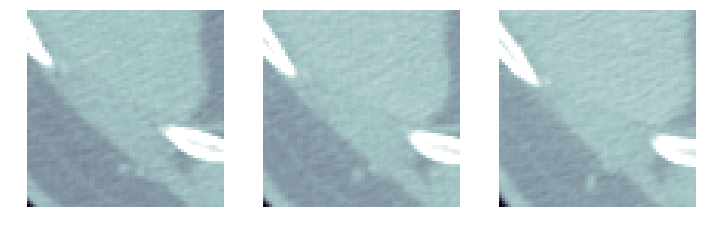

In [6]:
#working_path = "F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/Output/"
img_file = 'F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/output3d1/nodule/01X.npy'

imgs_to_process = np.load(img_file).astype(np.float64)
fig = plt.figure(figsize=(12,4))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.imshow(imgs_to_process[i,:,:], 'bone')
    ax.set_axis_off()

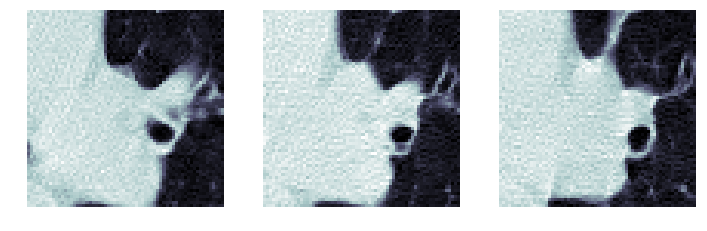

In [11]:
img_file = 'F:/8_Machine Learning/Bai tap Deeplearning/5_Lung cancer detection/output3d1/non_nodule/10X.npy'
imgs_to_process = np.load(img_file).astype(np.float64)
fig = plt.figure(figsize=(12,4))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.imshow(imgs_to_process[i,:,:], 'bone')
    ax.set_axis_off()

In [21]:
import PIL

In [22]:
img = PIL.Image.fromarray(arr)

TypeError: Cannot handle this data type

TypeError: Invalid dimensions for image data

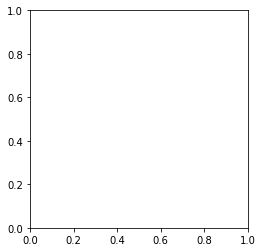

In [24]:
plt.imshow(arr)